# Quantum Computing Experimentation with Amazon Braket
### Chapter 9 - Running QAOA on Simulators and Amazon Braket Devices

© 2021, 2022, 2023 Packt Publishing

Written by Alex Khan

In [1]:
# If running for the first time uncomment the lines below and install the following modules
#!pip3 install numpy
#!pip3 install scipy --user
#!pip3 install amazon-braket-sdk
#!pip3 install dwave-ocean-sdk
#!pip3 install seaborn --user
#!pip3 install matplotlib

In [46]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [4]:
import numpy as np

In [5]:
from scipy.optimize import minimize, curve_fit


In [6]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [7]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [8]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [9]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Aspen-M-3','Harmony','Lucy','Aquila', 'Aria 2']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [10]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [11]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [12]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, shots, local=True, device_name='', s3_folder='', display_binary=False, disable_qubit_rewiring=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=shots).result()
    else:
        device=set_device(device_name)
        if shots==0:
            measured_qubits=len(circuit.qubits)
            num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        else:
            num_reads=shots
        print('device', device)
        print('num reads', num_reads)
        if device_name=='Aspen-M-3':
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder, disable_qubit_rewiring=disable_qubit_rewiring).result()
        else:
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        if device_name in (['SV1','TN1']):
            actual_simulator_cost(device, result)
        else:
            estimate_cost(device, num_reads)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [13]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [14]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [15]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [16]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [17]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [18]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [19]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [20]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [21]:
def matrix_to_polynomial(objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    #extra_qubits={}
    #r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    return(eq)

In [22]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [23]:
def plot_results_mc(counts):

    figure(figsize=(10, 6), dpi=100)

    len1=len(objective)
    print('valid values',-max_val/2,'to',max_val/2)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        #print(val[1], val[1][0:len1], result, val[0])
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])

    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [24]:
def sum_energy(Q,array):
    vals=[]
    for i in range(len(array)):
        if array[int(i)]=='1':
            vals.append(i)
            
    sum=0
    #print(vals)
    for i in (vals):
        sum+=Q[int(i),int(i)]
    for i in (vals):
        for j in (vals):
            if i<j:
                sum+=Q[int(i),int(j)]
    return(sum)
            
    

In [25]:

def param_optimizer(param1, param2, Q, shots):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))
    D_count=np.zeros((len(param1),len(param2)))
    lowest_count=0

    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            qc=qc.x(range(len(Q))).h(range(len(Q)))
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            device = LocalSimulator()
            result = device.run(qc, shots=shots).result()
            counts = result.measurement_counts

            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            D_count[p1,p2]=quantity[index[0]]
    
    # Find lowest value found with highest count
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):   
            if D[p1,p2]<=lowest_energy:
                lowest_energy=D[p1,p2]
                if lowest_count < D_count[p1,p2]:
                    lowest_count=D_count[p1,p2]
                    lowest_param1=param1[p1]
                    lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
            
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D, 
        annot=True, 
        xticklabels=[f'{x:.00}' for x in param2], 
        yticklabels=[f'{x:.00}' for x in param1],  
        linewidths=.5, 
        cmap="YlGnBu", 
        annot_kws = {'alpha': 1})    
    plt.title('parameter landscape - energy');
    plt.tight_layout();
    plt.show()
    
    # repeat with counts
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D_count, 
        annot=True, 
        xticklabels=[f'{x:.00}' for x in param2], 
        yticklabels=[f'{x:.00}' for x in param1],  
        linewidths=.5, 
        cmap="YlGnBu", 
        annot_kws = {'alpha': 1})    
    plt.title('parameter landscape - counts');
    plt.tight_layout();
    plt.show()
    
    return(lowest_param1, lowest_param2, lowest_energy)

In [26]:
def param_optimizer_device(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))
    D_count=np.zeros((len(param1),len(param2)))
    lowest_count=0

    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-M-2' :
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, True)
            counts = result.measurement_counts
            
            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            D_count[p1,p2]=quantity[index[0]]
            

    # Find lowest value found with highest count
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):   
            if D[p1,p2]<=lowest_energy:
                lowest_energy=D[p1,p2]
                if lowest_count < D_count[p1,p2]:
                    lowest_count=D_count[p1,p2]
                    lowest_param1=param1[p1]
                    lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
            
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D, 
        annot=True, 
        xticklabels=[f'{x:.000}' for x in param2], 
        yticklabels=[f'{x:.000}' for x in param1],  
        linewidths=.5, 
        cmap="YlGnBu", 
        annot_kws = {'alpha': 1})    
    plt.title('parameter landscape - energy');
    plt.tight_layout();
    plt.show()
    
    # repeat with counts
    plt.figure(1, figsize=[7, 5])
    sns.heatmap(D_count, 
        annot=True, 
        xticklabels=[f'{x:.00}' for x in param2], 
        yticklabels=[f'{x:.00}' for x in param1],  
        linewidths=.5, 
        cmap="YlGnBu", 
        annot_kws = {'alpha': 1})    
    plt.title('parameter landscape - counts');
    plt.tight_layout();
    plt.show()
    return(lowest_param1, lowest_param2, lowest_energy)

In [27]:
def schedule_task(qc, shots, device):
    if device.name=='Aspen-M-3':
        qc_task = device.run(qc, shots=shots, 
                             s3_destination_folder=s3_folder, 
                             disable_qubit_rewiring=False,
                             poll_timeout_seconds=5*24*60*60)
    else:
        qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60)
    #qc_status = qc_task.state()
    print('ID of task:', qc_task.id)
    #print('Status of task:', qc_status)
    
    # to retrieve task use
    # results, metadata, counts=recover_task_sum(qc_task_id)
    return(qc_task.id)

In [28]:
def recover_task(task_id):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    #print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        #print('Measurement counts:', counts)

        return(results, metadata, counts)
       
       

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

In [29]:
def schedule_optimize_bqm_task(param1, param2, Q, shots, device):
    
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        if device.name=='Aspen-M-3' :
                            qc=qc.cnot(i, j).rz(j, param1[p]*Q[i,j]).cnot(i, j)
                        else:
                            qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])
    
    qc_task_id=schedule_task(qc, shots, device)
    
    return(qc_task_id)


In [30]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

In [31]:
def func_bqm(x):
    # This function is used by the scipy optimizer
    # It takes a matrix Q and returns the lowest energy found for a single set of parameters in x
    # It allows scipy to find the optimal single set of parameters
    #
    global Q
    global shots
    global param1_list
    global param2_list
    global min_value_list
    global quantity_list
    global solution_list
    global SV
    param1=x[0]
    param2=x[1]
    sum=0
    qc=Circuit()
    
    Qubits=len(Q)
    qc=qc.x(range(Qubits)).h(range(Qubits))
    for i in range(Qubits):
        if Q[i,i]!=0:
            qc=qc.rz(i,-2*param1*Q[i,i])
    for i in range (Qubits):
        for j in range (Qubits):
            if i<j:
                if Q[i,j]!=0:
                    qc=qc.zz(i,j,2*param1*Q[i,j])
    for i in range(len(Q)):
        qc=qc.rx(i,2*param2)
    
    device = LocalSimulator()
    solution=[]
    quantity=[]
    energy=[]
    
    if SV==True:
        qc=qc.state_vector()
        result = device.run(qc, shots=0).result()
        #print(result.values)
        counter=0
        for res in (result.values[0]):
            quantity.append(abs(res)**2)
            keys=format(counter, '0'+str(Qubits)+'b')
            #print(keys)
            solution.append(keys)
            counter+=1
            energy.append(sum_energy(Q,keys))

    else:
        result = device.run(qc, shots=shots).result()
        counts = result.measurement_counts

        for keys,values in zip(counts.keys(),counts.values()):
            solution.append(keys)
            quantity.append(values)
            energy.append(sum_energy(Q,keys))
    
    index=np.argsort(energy)
    param1_list.append(param1)
    param2_list.append(param2)
    min_value_list.append(energy[index[0]])
    solution_list.append(solution[index[0]])
    quantity_list.append(quantity[index[0]])
    return(energy[index[0]])

In [32]:
def optimize_bqm(param1, param2, Q, shots):
    # This function optimizes 
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for keys,values in zip(counts.keys(),counts.values()):
        solution.append(keys)
        quantity.append(values)
        energy.append(sum_energy(Q,keys))
    energy_np=np.array(energy)
    index=np.argsort(energy)
    
    
    plt.title('param1:'+str(param1)+' param2:'+str(param2))
    plt.xlabel('cost')
    #plt.xlim(-3, 8)
    plt.ylabel('occurrence')
    #plt.ylim(0,2700)
    plt.scatter(energy,quantity)

    plt.show()
    return(solution[index[0]],energy[index[0]],quantity[index[0]])


In [33]:
def optimize_bqm_SV1(param1, param2, Q, shots):
    # This function optimizes 
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for keys,values in zip(counts.keys(),counts.values()):
        solution.append(keys)
        quantity.append(values)
        energy.append(sum_energy(Q,keys))
    energy_np=np.array(energy)
    index=np.argsort(energy)
    
    
    plt.title('param1:'+str(param1)+' param2:'+str(param2))
    plt.xlabel('cost')
    #plt.xlim(-3, 8)
    plt.ylabel('occurrence')
    #plt.ylim(0,2700)
    plt.scatter(energy,quantity)

    plt.show()
    return(solution[index[0]],energy[index[0]],quantity[index[0]])


In [34]:
def ProbabilisticSampler(Q,plot_limit,offset=0, min_limit=0, max_limit=0):
    #(C) 2021, 2022 Alex Khan 

    
    from itertools import combinations
    import numpy as np
    import pandas as pd
    import random
    import math
    import matplotlib.pyplot as plt
    
    def nCr(n,r):
        f = math.factorial
        return int(f(n) / f(r) / f(n-r))
    
    def random_combination(iterable, r):
        "Random selection from itertools.combinations(iterable, r)"
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        return list(tuple(pool[i] for i in indices))
    
    def sum(i_list, Q):
        sum_lq=0

        for i in (i_list):
            for j in (i_list):
                
                sum_lq+=Q[i][j]
            
        return(sum_lq+offset)
    
    
    N=len(Q[0])
    if max_limit==0:
        max_limit=N
    t= (2**N)-1
    
    e_min=9999999
    count=0
    min_list=[]
    plot_data=[]
    x_label=[]
    comb_list=[]
    for n in range(min_limit,max_limit+1):  # for groups of items from 1 to N
        comb=nCr(N,n)
        comb_list.append(comb)
        #print('--m ', m, comb)
        if comb>plot_limit:
            combf=plot_limit
        else:
            combf=comb
                
        for i in range (combf):
            i_list=random_combination(range(N), n)
            plot_data.append(sum(list(i_list),Q))
            x_label.append(n)
            
            if sum(list(i_list),Q)<e_min:  

                    e_min=sum(list(i_list),Q)  
                    min_count=n
                    min_list=list(i_list)
                    
                    #print(list(i_list), sum(list(i_list),Q))
            count+=1
    plt.plot(x_label,plot_data)
    plt.ylabel('Energy')
    plt.show()
    
    print('Best found:', min_list)
    print('count:', min_count)
    print('Energy:', e_min)
    print('Solutions Sampled:', count)
    #print('Total Possible solutions:', comb_list)
    return min_list, e_min, comb_list

In [35]:
def run_dwave(Q):
    from dwave.system.samplers import DWaveSampler
    from dwave.system.composites import EmbeddingComposite
    import dimod 
    
    sampler = EmbeddingComposite(DWaveSampler())

    
    #Estimate cost and shots
    dim=len(Q)
    shots=25*2**dim
    print(shots)
    if shots>3000:
        shots=3000
   
    # create BQM
    linear={i:Q[i][i] for i in range(dim)}
    quadratic={(i,j):Q[i][j] for i in range(dim) for j in range(dim) if i<j}
    
    vartype = dimod.BINARY
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, vartype)
    
    # Note: reduce shots if you want to reduce costs
    chain_strength = dim/5
    print('chain strength:',chain_strength, 'shots:', shots)

    # run sampler
    response = sampler.sample(bqm, num_reads=shots, chain_strength=chain_strength)
                              
    print(response)
                              
    solution=""
    for i in response:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print('decimal equivalent:',int(solution,2))
                              
    print('Validate energy',sum_energy(Q,solution))
    return(response)

In [36]:
def run_neal(Q):
    import neal
    import dimod 
    Nsampler = neal.SimulatedAnnealingSampler()
    QDWaveSA = dimod.BinaryQuadraticModel(Q, dimod.BINARY)
    SAresponse = Nsampler.sample(QDWaveSA)
    for SAsample in SAresponse.data():
        print( SAsample)
    solution=""
    for i in SAresponse:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print(int(solution,2))
    return(SAresponse)

In [37]:
def create_aspen_11_matrix():
    import networkx as nx
    import matplotlib.pyplot as plt
    import random

    device=set_device('Aspen-11')
    aspen_graph = device.properties.paradigm.connectivity.connectivityGraph
    #print(f"the connectivity of {device.name} is: {aspen_graph}")


    G = nx.Graph()
    A=np.zeros((48,48))
    for i in aspen_graph:
        G.add_node(i)
        #print(i)
        A[int(i),int(i)]=-random.randrange(1,5)
        for j in (aspen_graph[i]):
            #print(i,j)
            if int(i)<=int(j):
                A[int(i),int(j)]=random.randrange(1,20)/10
                G.add_edge(i,j)
            else:
                #print('flip')
                A[int(j),int(i)]=random.randrange(1,20)/10
                G.add_edge(j,i)

    #print(A)  
    #print(len(A))
    np.savetxt('Aspen_matrix.csv', A, delimiter=',')
    #print(nx.spring_layout(G))
    #subax1 = plt.subplot(121)
    #nx.draw(G) # default spring_layout
    subax2 = plt.subplot()
    nx.draw(G, pos=nx.spring_layout(G), node_shape='.', node_color='r', edge_color='b')


In [38]:
def create_aspen_M2_matrix():
    import networkx as nx
    import matplotlib.pyplot as plt
    import random

    device=set_device('Aspen-M-2')
    aspen_graph = device.properties.paradigm.connectivity.connectivityGraph
    #print(f"the connectivity of {device.name} is: {aspen_graph}")


    G = nx.Graph()
    A=np.zeros((148,148))
    for i in aspen_graph:
        G.add_node(i)
        #print(i)
        A[int(i),int(i)]=-random.randrange(1,5)
        for j in (aspen_graph[i]):
            #print(i,j)
            if int(i)<=int(j):
                A[int(i),int(j)]=random.randrange(1,20)/10
                G.add_edge(i,j)
            else:
                #print('flip')
                A[int(j),int(i)]=random.randrange(1,20)/10
                G.add_edge(j,i)

    #print(A)  
    #print(len(A))
    np.savetxt('Aspen_matrix.csv', A, delimiter=',')
    #print(nx.spring_layout(G))
    #subax1 = plt.subplot(121)
    #nx.draw(G) # default spring_layout
    subax2 = plt.subplot()
    nx.draw(G, pos=nx.spring_layout(G), node_shape='.', node_color='r', edge_color='b')


In [39]:
def generate_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                Q[i,j]=E[i,j]
            elif i==j:
                Q[i,j]=-E[i,j]
    return(Q)

In [40]:
def generate_sparse_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    terms=0
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                if E[i,j]>3:
                    Q[i,j]=E[i,j]
                    terms+=1
                    
            elif i==j:
                Q[i,j]=-E[i,j]
                terms+=1
    print('terms:',terms)
    return(Q)

In [41]:
def convert_aspen_to_tn1(T_raw):
    RtoN={}
    counter=0
    for i in range(len(T_raw)):
        if T_raw[i,i]!=0:
            RtoN[i]=counter
            counter+=1
    print(RtoN)

    TN=np.zeros((len(RtoN), len(RtoN)))

    for i in range(len(T_raw)):
        if T_raw[i,i]!=0:
            TN[RtoN[i],RtoN[i]]=T_raw[i,i]

    for i in range(len(T_raw)):
        for j in range(len(T_raw)):
            if i<j and T_raw[i,j]!=0:
                TN[RtoN[i],RtoN[j]]=T_raw[i,j] 

    print(TN)
    print(TN.shape)
    return(TN)

## 1. Further QAOA Considerations

### Full QAOA Hybrid Algorithm using classical parameter optimizer

In [42]:
# Test Params

param1=np.arange(0.1,0.8,0.15,dtype=float)
param2=np.arange(0.1,0.8,0.15,dtype=float)
print(param1)
print(param2)

[0.1  0.25 0.4  0.55 0.7 ]
[0.1  0.25 0.4  0.55 0.7 ]


In [43]:
file = open("IonQ_matrix.csv")
Q = np.loadtxt(file, delimiter=",")
file.close()
print(Q)


[[ 1.3  -0.63 -0.34 -0.3   0.22  0.1   0.03 -0.5   0.28 -0.8  -0.1 ]
 [ 0.    0.51 -0.25  0.42  0.45  0.89  0.09 -0.8  -0.74 -0.68 -0.2 ]
 [ 0.    0.    0.84  0.03 -0.3   0.5  -0.22  0.7  -0.3   0.6   0.3 ]
 [ 0.    0.    0.    0.75  0.51 -0.2   0.25  0.3  -0.03  0.03  0.4 ]
 [ 0.    0.    0.    0.    0.27 -0.65 -0.4   0.2  -0.46  0.54 -0.2 ]
 [ 0.    0.    0.    0.    0.    0.15 -0.95  0.51  0.67 -0.22 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.6   0.63  0.2   0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.25 -0.81 -0.59 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.01  0.3 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.6  -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1 ]]


In [48]:
# Quick check of answer using D-Wave
response=run_dwave(Q)

51200
chain strength: 2.2 shots: 3000
     0  1  2  3  4  5  6  7  8  9 10 energy num_oc. chain_b.
0    1  1  0  0  0  0  0  1  1  1  1   -2.5     187      0.0
1    1  1  0  0  0  0  0  1  1  1  0   -2.1      59      0.0
2    0  1  0  0  0  0  0  1  1  1  1  -2.05     103      0.0
3    1  1  0  0  0  0  0  1  0  1  1  -2.04      67      0.0
4    0  1  0  0  0  0  0  1  1  1  0  -1.75      42      0.0
5    1  1  0  0  0  0  1  1  0  1  1  -1.72      60      0.0
6    1  1  0  0  0  1  1  1  0  1  1  -1.64      51      0.0
7    1  1  0  0  0  0  1  1  1  1  1  -1.55      32      0.0
8    0  0  0  0  1  1  1  1  0  0  1  -1.52      95      0.0
9    1  1  0  0  1  0  0  1  1  1  1  -1.48      34      0.0
10   0  0  0  0  1  1  1  0  0  0  1  -1.48      97      0.0
11   1  1  0  0  0  0  1  1  1  1  0   -1.4      28      0.0
12   1  1  0  0  0  0  0  1  0  1  0  -1.34      11      0.0
13   0  1  0  0  0  0  0  1  0  1  1  -1.31      26      0.0
14   0  1  0  0  0  0  0  1  1  0  1  -1.29    

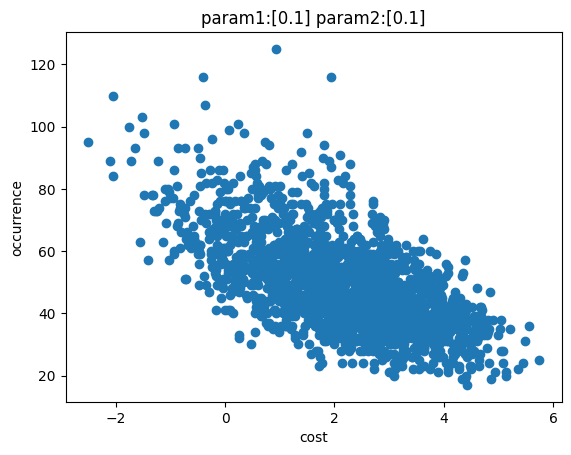

Parameters 0.1 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 95


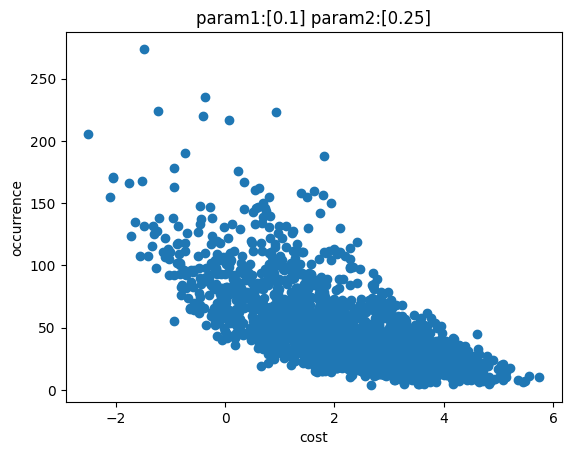

Parameters 0.1 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 206


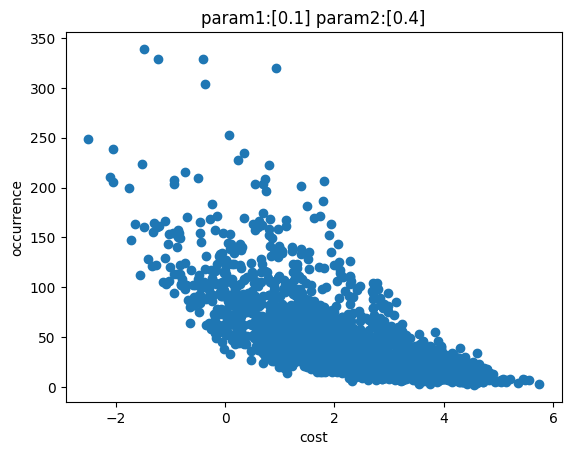

Parameters 0.1 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 249


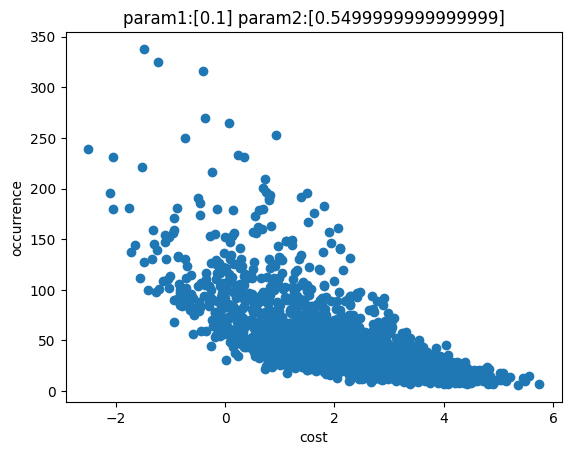

Parameters 0.1 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 239


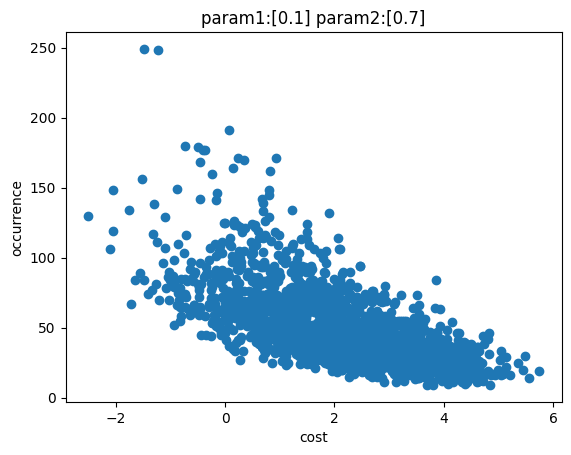

Parameters 0.1 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 130


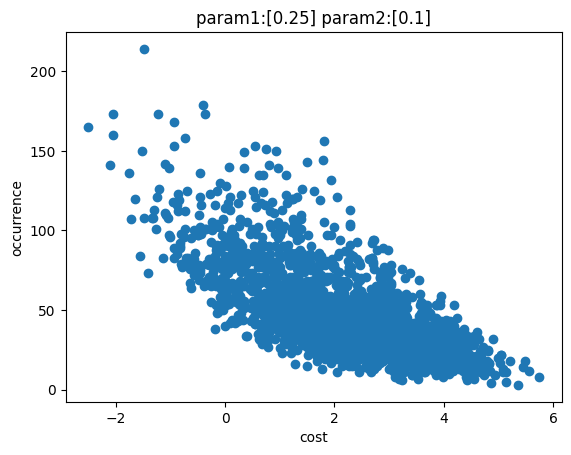

Parameters 0.25 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 165


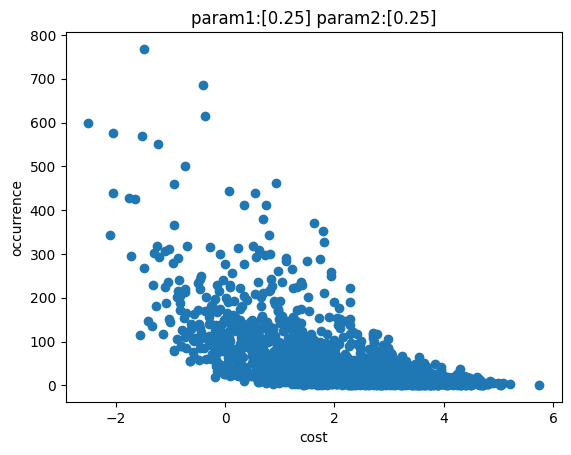

Parameters 0.25 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 598


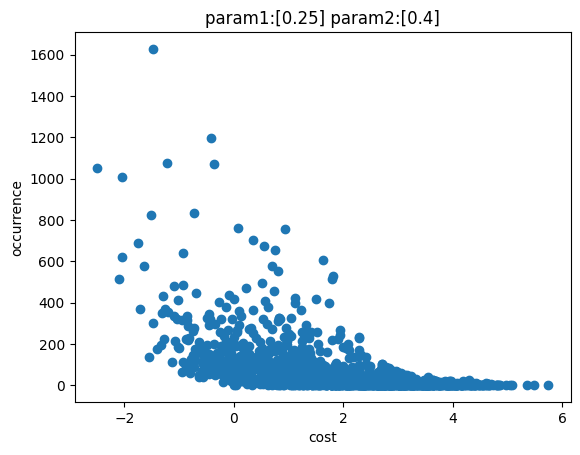

Parameters 0.25 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1051


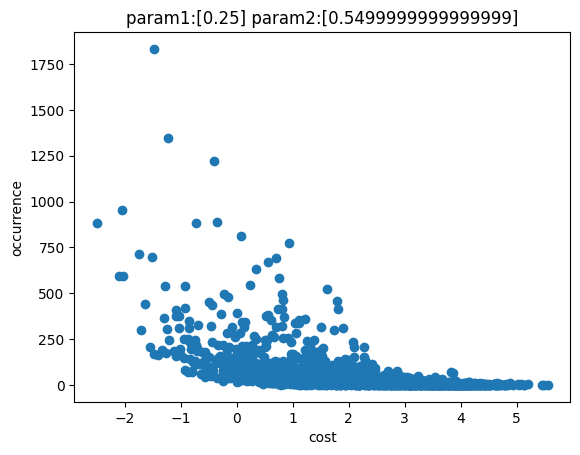

Parameters 0.25 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 885


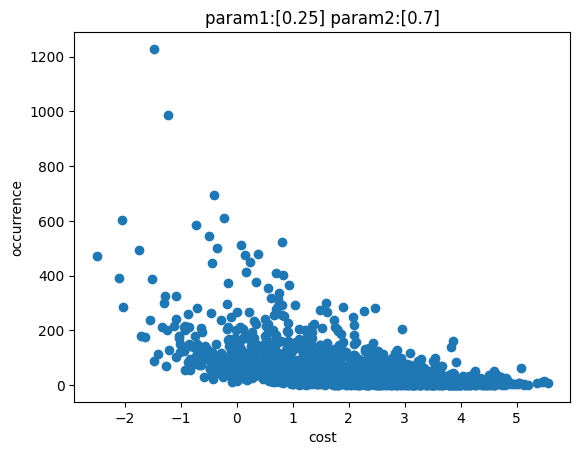

Parameters 0.25 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 471


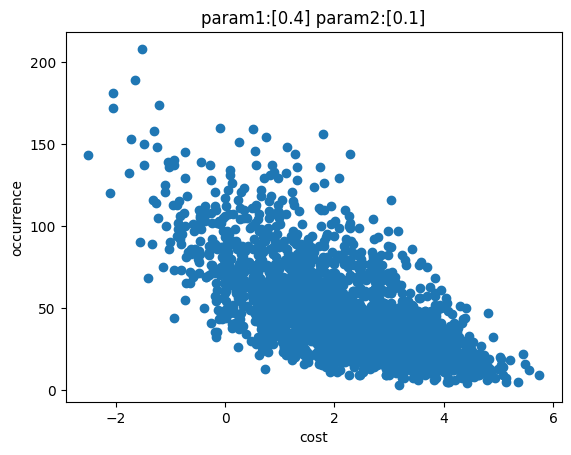

Parameters 0.4 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 143


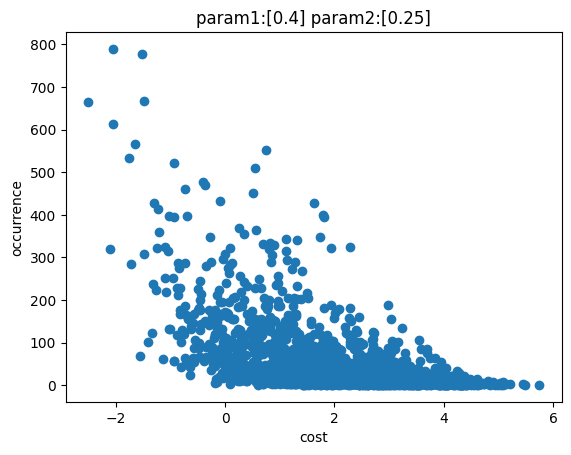

Parameters 0.4 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 664


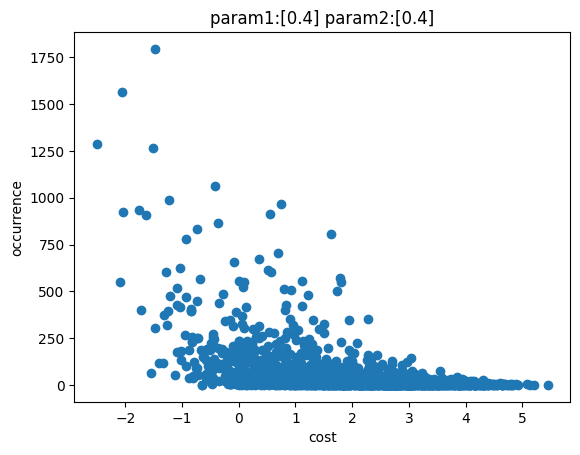

Parameters 0.4 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1289


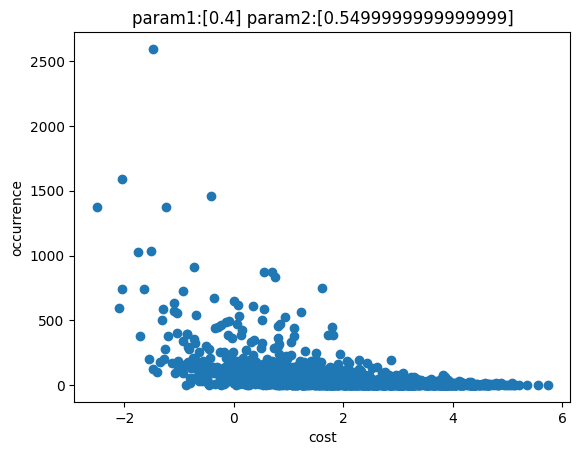

Parameters 0.4 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1373


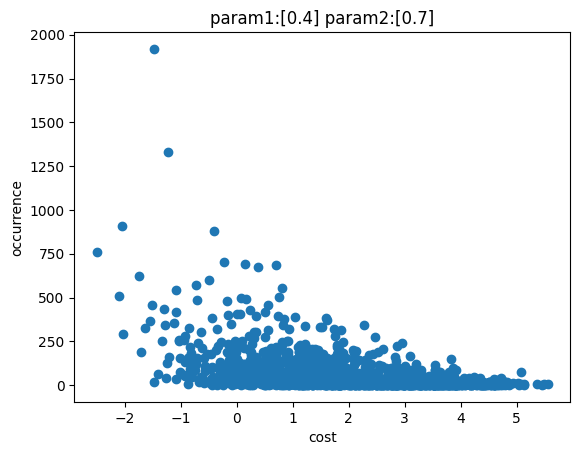

Parameters 0.4 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 757


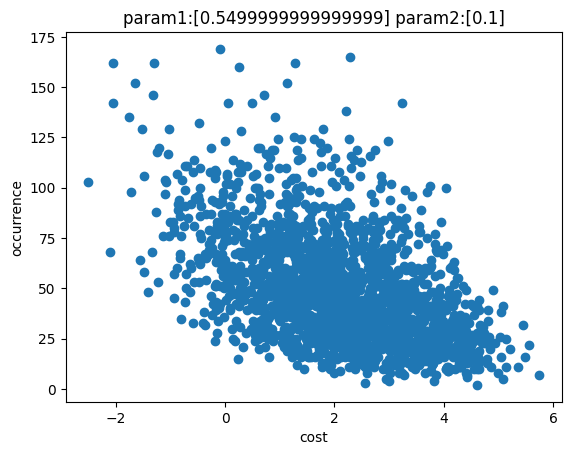

Parameters 0.5499999999999999 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 103


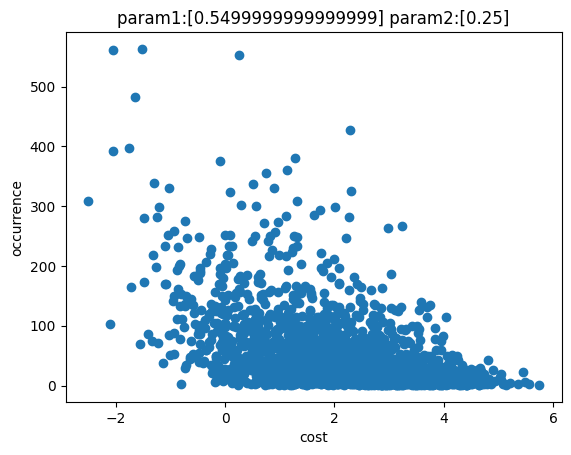

Parameters 0.5499999999999999 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 309


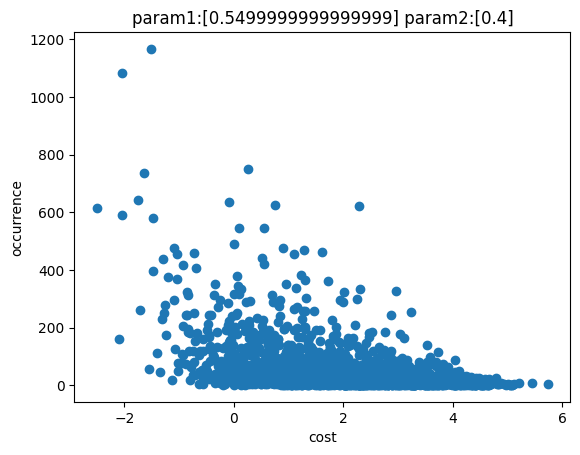

Parameters 0.5499999999999999 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 615


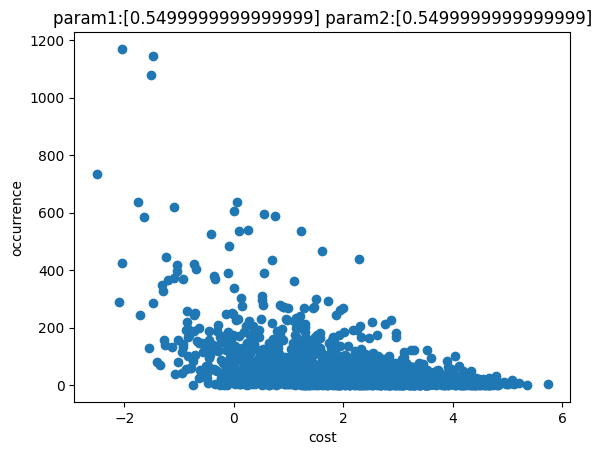

Parameters 0.5499999999999999 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 735


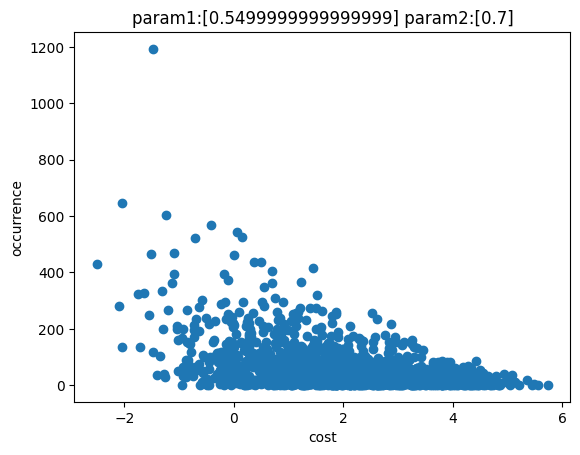

Parameters 0.5499999999999999 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 430


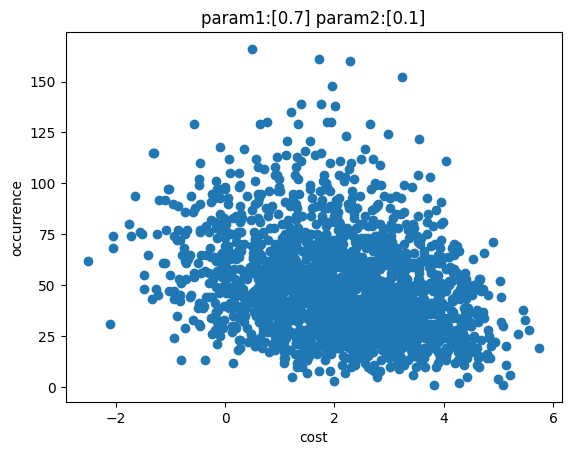

Parameters 0.7 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 62


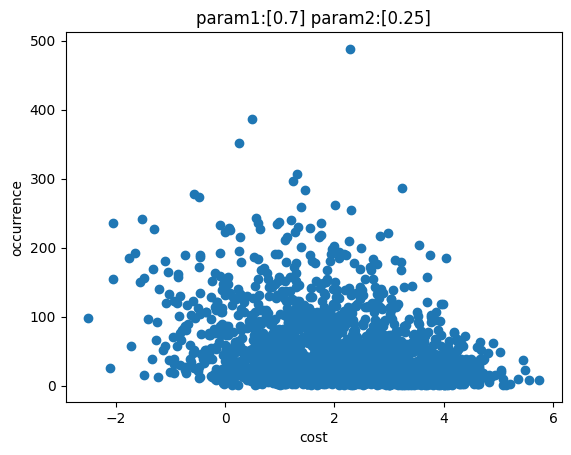

Parameters 0.7 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 98


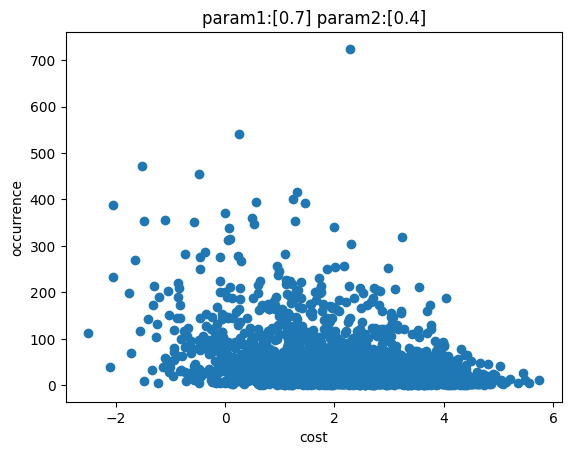

Parameters 0.7 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 112


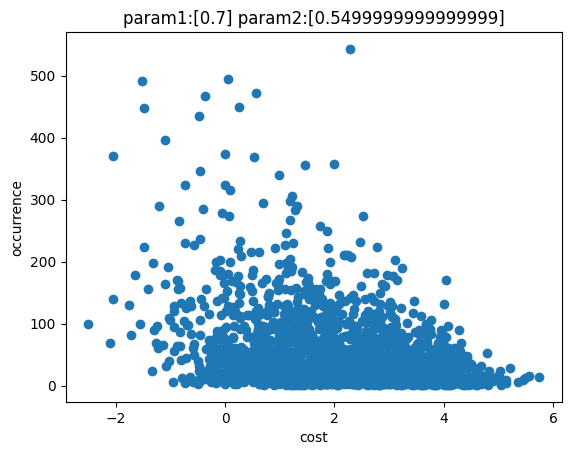

Parameters 0.7 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 100


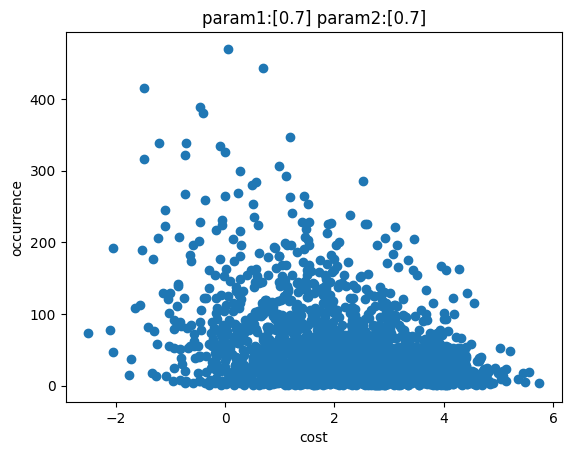

Parameters 0.7 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 74


In [46]:
# This example is overkill, however, it is to prove the point
# that carefully selected parameters increase the probability of the minimum value
# It also visualizes the probabilities and how the patern is shifting towards the lower values

for p1 in param1:
    for p2 in param2:
        solution,energy,quantity=optimize_bqm([p1], [p2], Q, 100000)
        print('Parameters', p1, p2, 'Solution:',solution, 'Energy:',energy, 'Qty Sampled',quantity)

In [ ]:
# Note param1=0.4 and param2=0.55 gave the most minimum values


T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

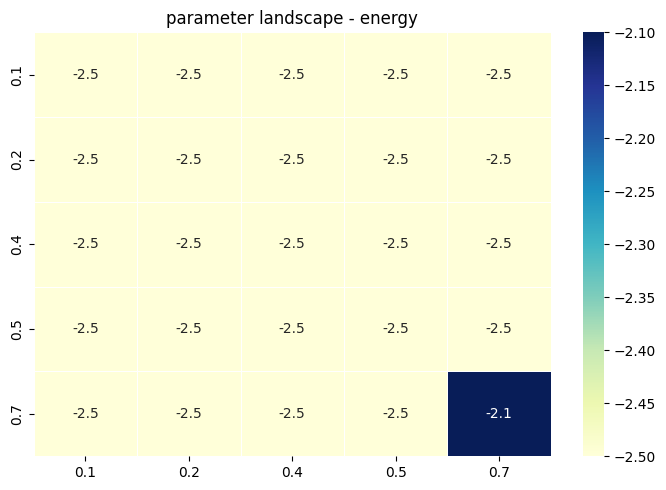

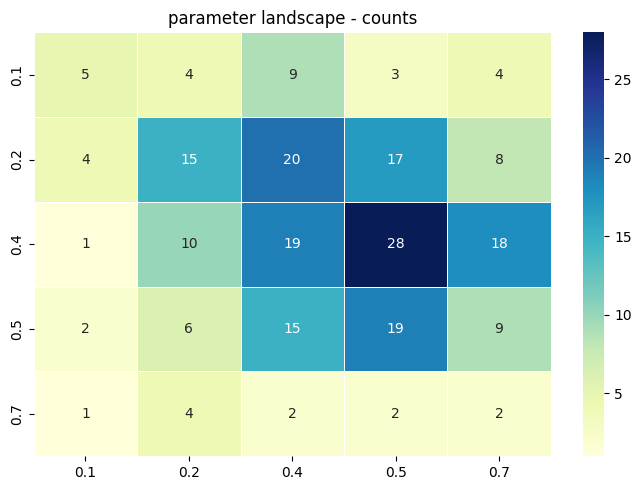

param1: 0.4 param2: 0.5499999999999999


In [89]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer(param1, param2, Q,2000)
print('param1:',ideal_param1, 'param2:',ideal_param2)

### Using Optimizer

In [49]:
shots=10
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, method='Nelder-Mead', tol=0.001)
print(res)

 final_simplex: (array([[0.2925    , 0.29625   ],
       [0.29250275, 0.29619736],
       [0.2924984 , 0.29624165]]), array([-2.5, -2.5, -2.5]))
           fun: -2.5000000000000004
       message: 'Optimization terminated successfully.'
          nfev: 53
           nit: 22
        status: 0
       success: True
             x: array([0.2925 , 0.29625])


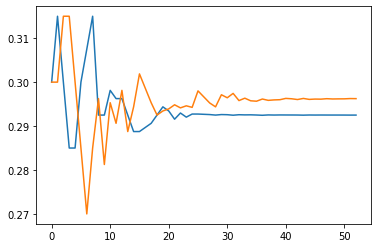

In [50]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

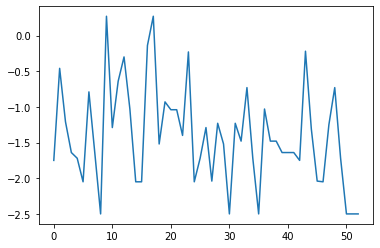

In [51]:
plt.plot(min_value_list)
plt.show()

In [52]:
np.min(min_value_list)

-2.5000000000000004

In [ ]:
#The optimizer with QAOA finds the minimum value of -2.5

Using Powell

In [57]:
shots=100
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, bounds=((0.1, 0.8), (0.1, 0.8)), method='Powell', tol=0.01)
print(res)

   direc: array([[1., 0.],
       [0., 1.]])
     fun: -2.5000000000000004
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 2
  status: 0
 success: True
       x: array([0.37328501, 0.39170915])


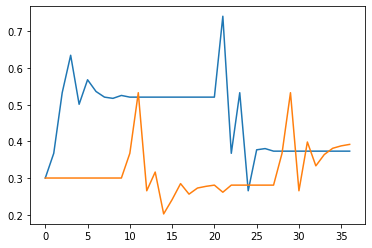

In [58]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

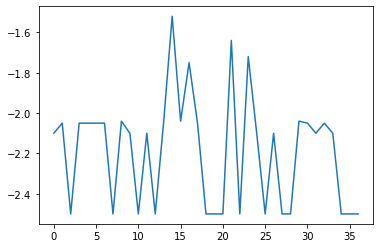

In [59]:
plt.plot(min_value_list)
plt.show()

In [56]:
np.min(min_value_list)

-2.5000000000000004

In [ ]:
#Finds the minimum multiple times

### Multiple step parameter optimization in QAOA

In [181]:
#---------
param1=np.arange(0.1,0.8,0.15,dtype=float)
param2=np.arange(0.1,0.8,0.15,dtype=float)
print(param1)
print(param2)
#---------

[0.1  0.25 0.4  0.55 0.7 ]
[0.1  0.25 0.4  0.55 0.7 ]


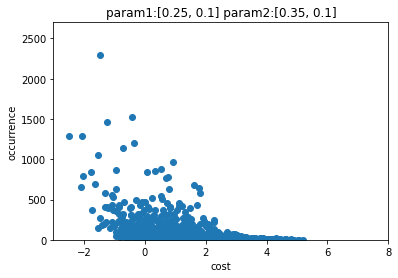

Parameters 0.1 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1283


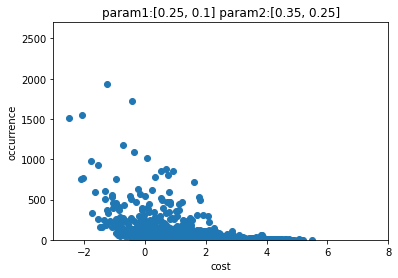

Parameters 0.1 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1517


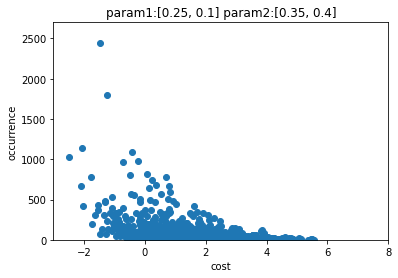

Parameters 0.1 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1027


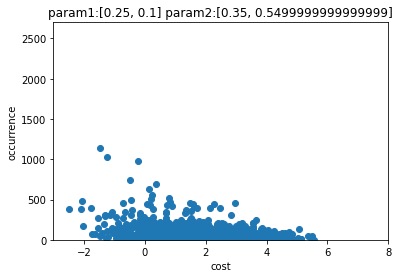

Parameters 0.1 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 388


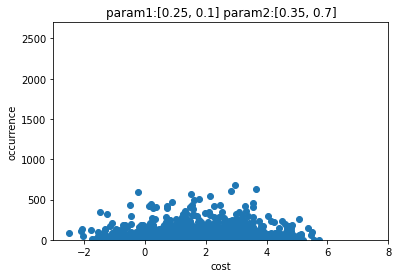

Parameters 0.1 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 81


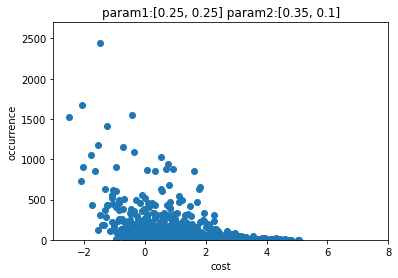

Parameters 0.25 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1530


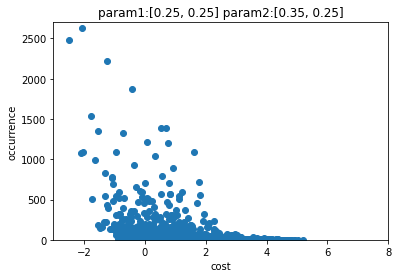

Parameters 0.25 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2480


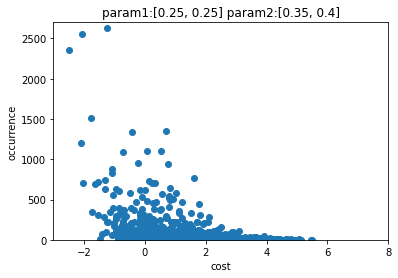

Parameters 0.25 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2354


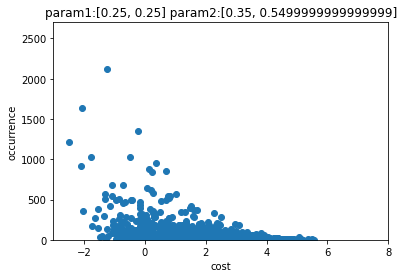

Parameters 0.25 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1219


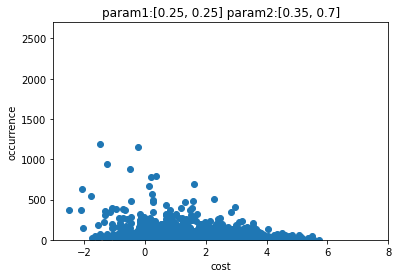

Parameters 0.25 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 375


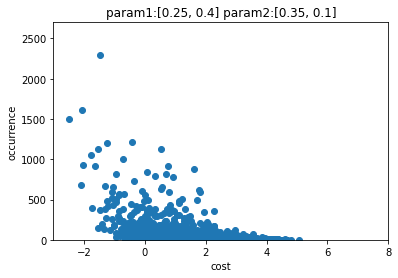

Parameters 0.4 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1495


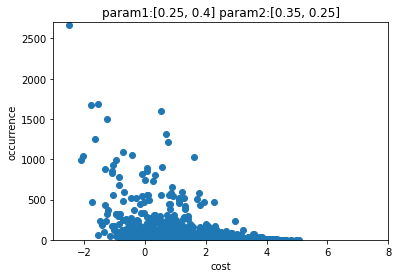

Parameters 0.4 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2671


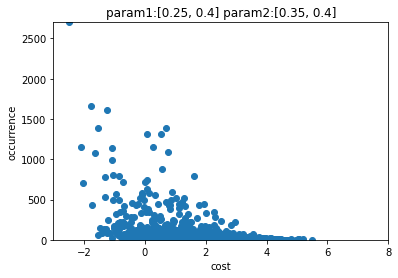

Parameters 0.4 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2707


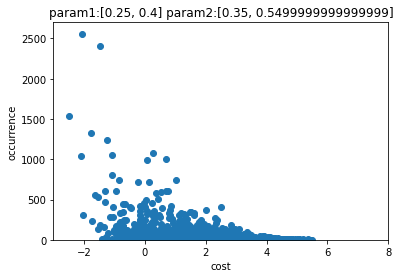

Parameters 0.4 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1538


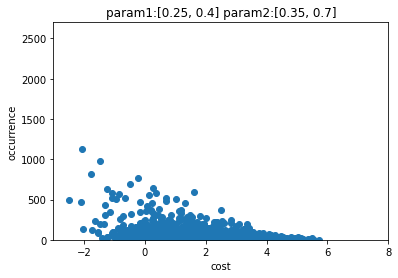

Parameters 0.4 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 492


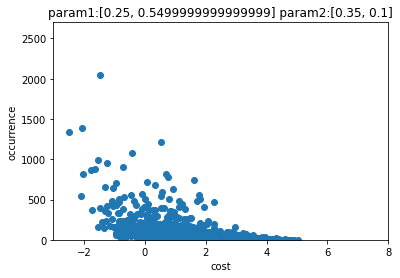

Parameters 0.5499999999999999 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1343


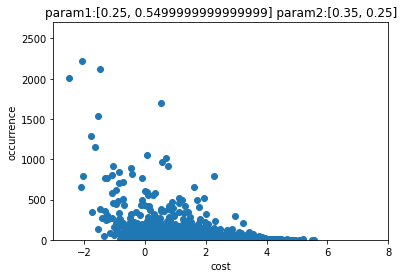

Parameters 0.5499999999999999 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 2006


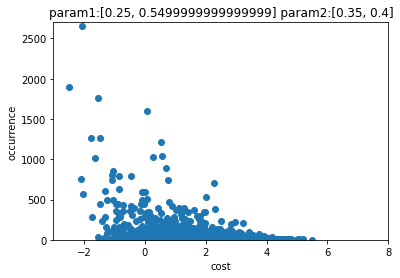

Parameters 0.5499999999999999 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1901


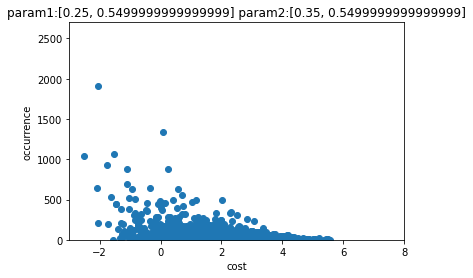

Parameters 0.5499999999999999 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1045


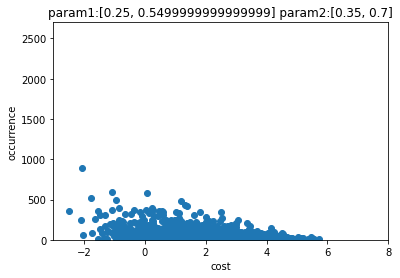

Parameters 0.5499999999999999 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 354


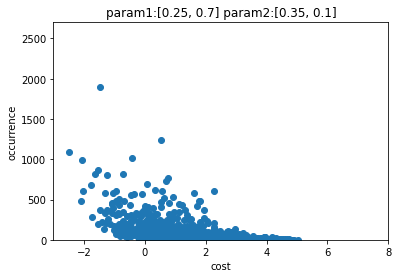

Parameters 0.7 0.1 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1095


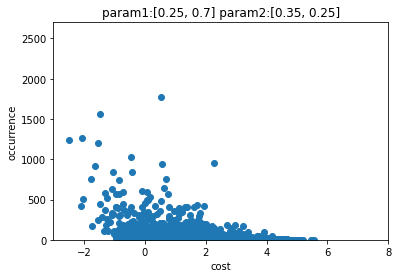

Parameters 0.7 0.25 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 1242


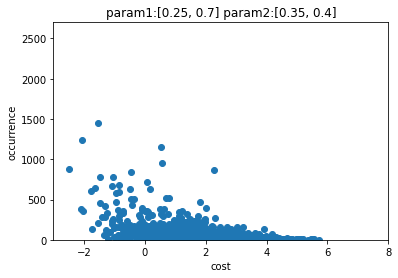

Parameters 0.7 0.4 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 885


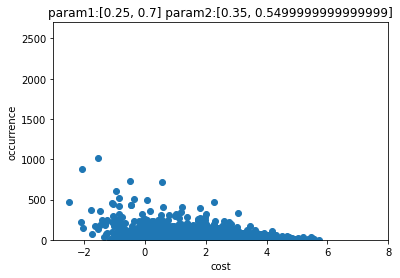

Parameters 0.7 0.5499999999999999 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 470


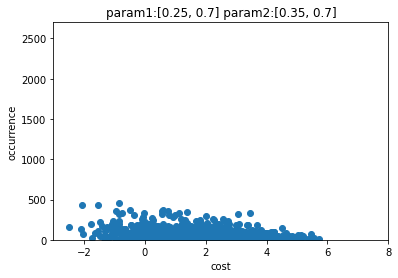

Parameters 0.7 0.7 Solution: 11000001111 Energy: -2.5000000000000004 Qty Sampled 161


In [188]:
for p1 in param1:
    for p2 in param2:
        solution,energy,quantity=optimize_bqm([0.25, p1], [0.35, p2], Q, 100000)
        print('Parameters', p1, p2, 'Solution:',solution, 'Energy:',energy, 'Qty Sampled',quantity)

In [60]:
# Seems like the following sequence of QAOA steps increased the probability of finding -2.5 the most.
# -2.5 was sampled 2707 times with the following parameters:
# param1: [0.25, 0.4], param2: [0.35,0.4]

### Benchmarking QAOA on Amazon Braket devices

### Optimizing 11x11 matrix

In [37]:
#Install scipy if not already installed
#!pip install scipy

In [37]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [61]:
file = open("IonQ_matrix.csv")
Q = np.loadtxt(file, delimiter=",")
print(Q)

[[ 1.3  -0.63 -0.34 -0.3   0.22  0.1   0.03 -0.5   0.28 -0.8  -0.1 ]
 [ 0.    0.51 -0.25  0.42  0.45  0.89  0.09 -0.8  -0.74 -0.68 -0.2 ]
 [ 0.    0.    0.84  0.03 -0.3   0.5  -0.22  0.7  -0.3   0.6   0.3 ]
 [ 0.    0.    0.    0.75  0.51 -0.2   0.25  0.3  -0.03  0.03  0.4 ]
 [ 0.    0.    0.    0.    0.27 -0.65 -0.4   0.2  -0.46  0.54 -0.2 ]
 [ 0.    0.    0.    0.    0.    0.15 -0.95  0.51  0.67 -0.22 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.6   0.63  0.2   0.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.25 -0.81 -0.59 -0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.01  0.3 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.6  -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1 ]]


In [62]:
matrix_to_polynomial(Q)

+1.3x₀²+0.51x₁²+0.84x₂²+0.75x₃²+0.27x₄²+0.15x₅²+0.35x₆²+0.25x₇²+0.5x₈²+0.6x₉²+0.1x₁₀²-0.63x₀x₁-0.34x₀x₂-0.3x₀x₃+0.22x₀x₄+0.1x₀x₅+0.03x₀x₆-0.5x₀x₇+0.28x₀x₈-0.8x₀x₉-0.1x₀x₁₀-0.25x₁x₂+0.42x₁x₃+0.45x₁x₄+0.89x₁x₅+0.09x₁x₆-0.8x₁x₇-0.74x₁x₈-0.68x₁x₉-0.2x₁x₁₀+0.03x₂x₃-0.3x₂x₄+0.5x₂x₅-0.22x₂x₆+0.7x₂x₇-0.3x₂x₈+0.6x₂x₉+0.3x₂x₁₀+0.51x₃x₄-0.2x₃x₅+0.25x₃x₆+0.3x₃x₇-0.03x₃x₈+0.03x₃x₉+0.4x₃x₁₀-0.65x₄x₅-0.4x₄x₆+0.2x₄x₇-0.46x₄x₈+0.54x₄x₉-0.2x₄x₁₀-0.95x₅x₆+0.51x₅x₇+0.67x₅x₈-0.22x₅x₉-0.4x₅x₁₀-0.6x₆x₇+0.63x₆x₈+0.2x₆x₉+0.25x₆x₁₀-0.81x₇x₈-0.59x₇x₉-0.4x₇x₁₀+0.01x₈x₉+0.3x₈x₁₀-0.1x₉x₁₀


'+1.3x₀²+0.51x₁²+0.84x₂²+0.75x₃²+0.27x₄²+0.15x₅²+0.35x₆²+0.25x₇²+0.5x₈²+0.6x₉²+0.1x₁₀²-0.63x₀x₁-0.34x₀x₂-0.3x₀x₃+0.22x₀x₄+0.1x₀x₅+0.03x₀x₆-0.5x₀x₇+0.28x₀x₈-0.8x₀x₉-0.1x₀x₁₀-0.25x₁x₂+0.42x₁x₃+0.45x₁x₄+0.89x₁x₅+0.09x₁x₆-0.8x₁x₇-0.74x₁x₈-0.68x₁x₉-0.2x₁x₁₀+0.03x₂x₃-0.3x₂x₄+0.5x₂x₅-0.22x₂x₆+0.7x₂x₇-0.3x₂x₈+0.6x₂x₉+0.3x₂x₁₀+0.51x₃x₄-0.2x₃x₅+0.25x₃x₆+0.3x₃x₇-0.03x₃x₈+0.03x₃x₉+0.4x₃x₁₀-0.65x₄x₅-0.4x₄x₆+0.2x₄x₇-0.46x₄x₈+0.54x₄x₉-0.2x₄x₁₀-0.95x₅x₆+0.51x₅x₇+0.67x₅x₈-0.22x₅x₉-0.4x₅x₁₀-0.6x₆x₇+0.63x₆x₈+0.2x₆x₉+0.25x₆x₁₀-0.81x₇x₈-0.59x₇x₉-0.4x₇x₁₀+0.01x₈x₉+0.3x₈x₁₀-0.1x₉x₁₀'

### Evaluate ideal single set of parameters to find minimum

Using scipy optimizer

In [63]:
shots=100
SV=False
Q=Q
param1_list=[]
param2_list=[]
min_value_list=[]
solution_list=[]
quantity_list=[]
params=[0.3,0.3]
res = minimize(func_bqm, params, method='Nelder-Mead', tol=0.001)
#Nelder-Mead, Powell,COBYLA

In [64]:
print(res)

 final_simplex: (array([[0.3       , 0.3       ],
       [0.29976563, 0.29953125],
       [0.29947266, 0.29988281]]), array([-2.5, -2.5, -2.5]))
           fun: -2.5000000000000004
       message: 'Optimization terminated successfully.'
          nfev: 24
           nit: 8
        status: 0
       success: True
             x: array([0.3, 0.3])


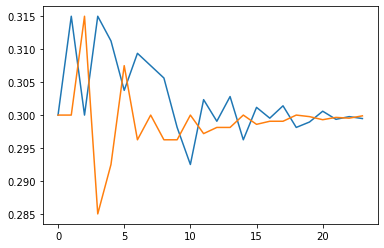

In [65]:
plt.plot(param1_list)
plt.plot(param2_list)
plt.show()

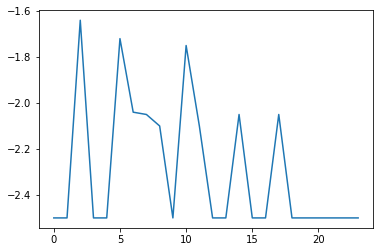

In [66]:
plt.plot(min_value_list)
plt.show()

In [127]:
for i in range(len(solution_list)):
    print(solution_list[i],quantity_list[i], min_value_list[i])

11010001011 1 -0.4399999999999997
01000001011 1 -1.31
01000001111 1 -2.0500000000000003
11000011010 1 -1.27
11001001111 1 -1.4799999999999995
01000001111 1 -2.0500000000000003
01000001111 1 -2.0500000000000003
11000011010 1 -1.27
00101110001 1 -0.3600000000000002
11000001111 1 -2.5000000000000004
11100001110 1 -0.8499999999999995
01000001011 1 -1.31
00001110001 1 -1.48
11001001111 1 -1.4799999999999995
01000001100 1 -1.09
01000001110 1 -1.7500000000000002
01000001110 1 -1.7500000000000002
01001001110 1 -0.7499999999999999
00001110001 1 -1.48
01000001111 1 -2.0500000000000003
01000001110 1 -1.7500000000000002
11010001111 1 -0.9299999999999996
00001001100 1 -0.050000000000000044
11000001011 1 -2.0399999999999996
01000001101 1 -1.2899999999999998
00001111001 1 -1.52
00001110001 1 -1.48
11000001110 1 -2.0999999999999996
01100001110 1 -0.16000000000000003
00101110001 1 -0.3600000000000002
01000011110 1 -1.0800000000000003
01000001110 1 -1.7500000000000002
11000001111 1 -2.5000000000000004
1

#### Caution: Execution of Code below will result in Amazon Braket Charges

Using SV1

In [48]:
Qubits=len(Q)
max_val=2**Qubits
param=np.arange(0.1,0.5,0.1,dtype=float)
print(param)

[0.1 0.2 0.3 0.4]


T   : |0|1|    2    |    3    |    4    |         5         |        6        |            7             |             8             |                 9                  |                  10                  |                      11                       |                       12                       |                      13                       |                 14                 |                 15                 |             16             |             17             |        18        |        19        |   20   |   21    |   22   |
                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{69: 1, 1452: 1, 1403: 1, 775: 1, 1734: 1, 1162: 1, 1456: 1, 1096: 1, 1376: 1, 554: 2, 1426: 1, 1774: 1, 497: 1, 58: 1, 854: 1, 1454: 1, 645: 1, 1484: 1, 380: 1, 853: 1, 1112: 1, 1370: 1, 1790: 1, 1101: 1, 1007: 1, 1629: 1, 1100: 1, 1971: 1, 714: 1, 860: 1, 1178: 1, 1523: 1, 747: 1, 903: 1, 975: 1, 1393: 1, 1669: 1, 1379: 1, 742: 1, 45: 1, 1202: 1, 1050: 1, 696: 1, 1604: 1, 12: 1, 870: 1, 1710: 1, 1976: 1, 527: 1, 984: 1, 1692: 1, 1795: 1, 122: 2, 1091: 1, 1425: 1, 1513: 1, 56: 1, 1749: 1, 1868: 1, 411: 1, 449: 1, 1022: 1, 326: 1, 1743: 1, 1707: 1, 1924: 1, 1997: 1, 1967: 1, 687: 1, 1300: 1, 691: 1, 240: 1, 21: 1, 773: 1, 178: 1, 1008: 1, 610: 1, 1968: 1, 1189: 1, 781: 1, 285: 1, 1754: 1, 1222: 1,

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{1525: 1, 1163: 1, 223: 2, 1134: 1, 1574: 1, 1627: 1, 568: 1, 371: 2, 112: 2, 1869: 1, 1329: 1, 696: 1, 856: 1, 1054: 1, 441: 1, 1185: 1, 1786: 1, 652: 1, 1571: 1, 897: 1, 1630: 1, 1824: 1, 687: 1, 457: 1, 1267: 1, 244: 1, 1558: 1, 2017: 1, 925: 1, 1408: 1, 990: 1, 1707: 1, 1246: 1, 1216: 1, 240: 2, 1035: 1, 1756: 1, 1658: 1, 769: 1, 381: 1, 1304: 1, 1415: 1, 1170: 1, 670: 1, 757: 1, 1840: 1, 869: 1, 801: 1, 1680: 1, 165: 1, 1394: 1, 591: 1, 638: 1, 1863: 1, 77: 1, 184: 1, 596: 1, 268: 1, 1053: 1, 678: 1, 1198: 1, 150: 1, 82: 1, 609: 1, 218: 1, 847: 1, 1306: 1, 154: 1, 772: 1, 1816: 1, 49: 1, 1586: 1, 208: 1, 1546: 1, 1322: 1, 934: 1, 1905: 1, 423: 1, 292: 1, 105: 1, 665: 1, 1795: 1, 1516: 1, 480:

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{950: 1, 388: 1, 1850: 1, 292: 1, 1338: 1, 898: 1, 381: 1, 357: 1, 1560: 1, 177: 1, 814: 1, 980: 1, 770: 1, 1012: 1, 677: 1, 1545: 1, 559: 1, 1457: 1, 1069: 1, 1699: 1, 1975: 1, 1066: 1, 120: 1, 46: 1, 1920: 1, 59: 3, 452: 1, 1864: 1, 543: 1, 1203: 1, 907: 1, 205: 1, 61: 1, 1610: 1, 1670: 1, 591: 1, 878: 1, 541: 1, 1218: 1, 1681: 1, 71: 1, 1214: 1, 1373: 1, 562: 1, 1714: 1, 527: 1, 374: 1, 1310: 1, 836: 1, 167: 1, 865: 1, 359: 1, 1941: 1, 241: 1, 640: 1, 1567: 1, 249: 1, 1957: 1, 112: 2, 110: 1, 404: 1, 1698: 1, 1932: 1, 486: 1, 482: 1, 1983: 1, 1023: 1, 1058: 1, 1231: 1, 240: 1, 1810: 1, 524: 1, 641: 1, 1722: 1, 1504: 1, 626: 1, 35: 1, 1555: 1, 1451: 1, 1662: 1, 1096: 1, 2046: 1, 113: 1, 375: 1, 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{320: 2, 1855: 1, 769: 1, 1594: 2, 1282: 1, 1846: 2, 4: 1, 117: 2, 1134: 1, 261: 1, 352: 1, 304: 1, 1546: 1, 377: 1, 797: 1, 980: 1, 1922: 1, 793: 1, 1740: 1, 1646: 1, 907: 1, 347: 1, 1025: 1, 264: 1, 1521: 1, 1544: 1, 584: 1, 1676: 1, 638: 2, 417: 1, 526: 1, 575: 1, 380: 1, 947: 1, 1149: 2, 113: 1, 685: 1, 1269: 1, 260: 1, 255: 1, 1344: 1, 523: 2, 1955: 1, 897: 1, 432: 1, 1932: 1, 248: 1, 1835: 1, 230: 1, 111: 1, 297: 1, 1522: 1, 1211: 1, 1722: 1, 217: 1, 1927: 1, 165: 1, 891: 1, 371: 1, 1659: 1, 643: 1, 372: 1, 484: 1, 817: 1, 1563: 1, 240: 1, 1783: 1, 1667: 1, 216: 1, 175: 1, 733: 1, 1273: 1, 205: 1, 1598: 1, 57: 1, 1971: 1, 1201: 1, 44: 1, 161: 1, 717: 1, 860: 1, 95: 1, 201: 1, 521: 1, 1297: 1

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  6 ms
total cost estimated: $ 7.500000000000001e-06
{567: 1, 1040: 1, 97: 1, 378: 1, 1208: 1, 1668: 1, 1142: 1, 1172: 1, 1017: 1, 1790: 1, 1733: 1, 1423: 1, 1507: 1, 98: 1, 1065: 1, 1705: 1, 365: 1, 37: 1, 1599: 1, 1268: 1, 156: 1, 640: 1, 171: 1, 1841: 1, 642: 1, 1723: 1, 888: 1, 1458: 1, 1194: 1, 2041: 1, 1187: 1, 1766: 1, 228: 1, 1671: 1, 1792: 1, 1033: 1, 93: 1, 216: 1, 1710: 2, 1156: 1, 788: 1, 836: 1, 1797: 1, 1282: 1, 1544: 1, 1120: 1, 71: 1, 934: 1, 780: 1, 609: 1, 896: 1, 1547: 1, 375: 1, 837: 1, 138: 1, 81: 1, 324: 1, 768: 1, 489: 1, 452: 1, 176: 1, 1010: 1, 558: 1, 538: 1, 1881: 1, 243: 1, 230: 1, 162: 1, 1122: 1, 291: 1, 847: 1, 690: 1, 198: 1, 1251: 1, 606: 1, 224: 1, 1947: 1, 1050: 1, 1679: 1, 119: 1, 1008: 1, 505: 1, 2029: 1, 352: 1,

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{580: 1, 1143: 1, 525: 1, 751: 1, 1930: 1, 1859: 1, 147: 1, 244: 1, 1650: 1, 988: 1, 134: 1, 1248: 1, 105: 1, 125: 1, 1659: 1, 1940: 1, 68: 1, 1806: 1, 1679: 2, 1785: 1, 1646: 1, 633: 1, 1819: 1, 493: 1, 1508: 1, 617: 1, 26: 1, 1263: 1, 32: 1, 368: 1, 1790: 1, 1870: 1, 497: 1, 861: 1, 380: 1, 1364: 1, 844: 1, 1547: 2, 588: 1, 1551: 1, 1643: 1, 1796: 1, 1571: 1, 1846: 1, 624: 1, 1209: 1, 1636: 1, 1609: 1, 1721: 1, 1973: 1, 11: 1, 519: 1, 384: 1, 185: 1, 1792: 2, 260: 1, 1868: 1, 1144: 1, 264: 1, 2041: 1, 1843: 1, 81: 1, 1723: 1, 28: 1, 136: 1, 540: 1, 124: 1, 992: 1, 1828: 1, 539: 1, 481: 1, 1083: 1, 446: 1, 1480: 1, 482: 1, 1255: 1, 666: 1, 457: 1, 1103: 1, 248: 1, 676: 1, 1544: 1, 524: 1, 1766: 1

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  8 ms
total cost estimated: $ 1e-05
{177: 1, 1551: 2, 1427: 1, 646: 1, 79: 1, 99: 1, 1694: 1, 45: 1, 1440: 1, 1151: 1, 772: 2, 1567: 2, 638: 2, 525: 2, 1319: 1, 1657: 1, 400: 1, 124: 1, 368: 1, 497: 1, 1562: 1, 993: 1, 227: 1, 679: 1, 1379: 1, 685: 1, 1843: 1, 373: 1, 518: 1, 1203: 1, 34: 1, 404: 1, 113: 1, 189: 1, 348: 1, 178: 1, 112: 1, 1466: 1, 799: 1, 239: 1, 1135: 1, 1476: 1, 1539: 1, 965: 1, 1862: 1, 496: 1, 1920: 1, 377: 1, 380: 1, 160: 1, 1345: 1, 1274: 1, 353: 1, 543: 1, 889: 1, 121: 1, 340: 1, 125: 1, 365: 1, 250: 1, 1999: 1, 1312: 1, 77: 1, 637: 1, 1775: 1, 140: 1, 205: 1, 1915: 1, 118: 1, 1393: 1, 910: 1, 111: 1, 179: 1, 1396: 1, 822: 1, 570: 1, 1615: 1, 1934: 1, 1162: 1, 1887: 1, 1546: 1, 703: 1, 1292: 1, 7: 1, 1147: 1, 50: 1, 852: 1, 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{500: 2, 140: 1, 639: 1, 33: 2, 1273: 1, 1535: 1, 134: 1, 1034: 1, 452: 1, 1676: 1, 184: 1, 372: 1, 115: 1, 1706: 1, 25: 1, 772: 1, 496: 2, 645: 1, 793: 1, 81: 1, 1548: 1, 102: 1, 900: 1, 49: 2, 31: 1, 518: 1, 241: 2, 103: 1, 1932: 1, 337: 1, 1154: 1, 369: 1, 368: 2, 225: 1, 1162: 1, 1679: 1, 204: 1, 113: 1, 109: 1, 1855: 1, 79: 1, 527: 2, 122: 1, 1880: 1, 1797: 1, 738: 1, 532: 1, 1920: 1, 30: 1, 45: 1, 1032: 1, 50: 1, 613: 1, 1264: 1, 621: 1, 256: 1, 24: 2, 1538: 1, 254: 1, 635: 1, 668: 1, 845: 1, 497: 2, 84: 1, 774: 1, 143: 1, 611: 1, 229: 1, 152: 1, 43: 1, 391: 1, 61: 1, 112: 2, 121: 1, 197: 1, 818: 1, 353: 1, 1432: 1, 1613: 1, 816: 1, 534: 1, 1935: 1, 525: 1, 1710: 1, 123: 1, 132: 1, 124: 1, 1

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{188: 1, 1774: 1, 852: 1, 956: 1, 394: 1, 1198: 1, 215: 1, 1546: 1, 325: 1, 1550: 1, 203: 1, 1816: 1, 1812: 1, 1137: 1, 160: 1, 1404: 1, 650: 1, 285: 1, 1860: 2, 1870: 1, 74: 1, 667: 1, 1799: 1, 638: 1, 129: 1, 449: 1, 306: 1, 230: 1, 133: 1, 9: 1, 773: 1, 324: 1, 1927: 1, 1176: 1, 1238: 1, 193: 1, 676: 1, 1639: 1, 178: 1, 1026: 1, 1522: 2, 1361: 1, 1041: 1, 2025: 1, 135: 1, 1470: 1, 697: 1, 1963: 1, 1423: 1, 1604: 1, 1013: 1, 863: 1, 1498: 1, 1302: 1, 1800: 1, 1649: 1, 40: 1, 1081: 1, 899: 1, 537: 1, 1921: 2, 884: 1, 101: 1, 1528: 1, 1905: 1, 336: 1, 1053: 1, 1256: 1, 1944: 1, 100: 1, 960: 1, 1149: 1, 742: 1, 1268: 1, 777: 1, 898: 1, 662: 1, 1403: 1, 320: 1, 2005: 1, 1139: 1, 1661: 1, 1356: 1, 53

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{56: 1, 97: 1, 84: 1, 1412: 1, 796: 1, 1394: 1, 187: 1, 220: 1, 642: 1, 225: 1, 1080: 1, 1250: 1, 769: 1, 518: 1, 786: 1, 380: 1, 1264: 1, 134: 1, 1999: 1, 1591: 1, 571: 1, 57: 2, 1583: 1, 1124: 1, 910: 1, 176: 1, 583: 1, 1369: 1, 1860: 1, 224: 1, 1531: 1, 237: 1, 1612: 1, 1931: 1, 413: 1, 645: 1, 784: 1, 908: 1, 136: 2, 337: 1, 1507: 1, 633: 1, 1473: 1, 16: 1, 229: 1, 964: 1, 1551: 1, 1630: 1, 1826: 1, 1166: 1, 670: 1, 1195: 1, 1185: 1, 114: 1, 432: 1, 1924: 1, 797: 1, 1136: 1, 1933: 1, 255: 1, 1955: 1, 1915: 1, 1101: 1, 1835: 1, 1663: 1, 1781: 1, 370: 1, 113: 2, 1921: 1, 1549: 1, 1801: 1, 1265: 1, 1766: 1, 48: 1, 798: 1, 496: 1, 32: 1, 376: 1, 400: 1, 421: 1, 34: 1, 132: 1, 1145: 1, 377: 1, 1629

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  8 ms
total cost estimated: $ 1e-05
{1594: 1, 1818: 1, 837: 1, 1807: 2, 527: 1, 132: 1, 43: 1, 774: 1, 1200: 2, 1723: 2, 321: 3, 432: 1, 845: 2, 1477: 1, 1032: 1, 1656: 1, 1932: 1, 225: 1, 162: 1, 637: 2, 1500: 1, 176: 3, 289: 1, 175: 1, 128: 1, 226: 1, 539: 1, 924: 1, 591: 1, 1082: 1, 77: 1, 1520: 1, 416: 1, 320: 1, 1921: 1, 34: 1, 1152: 1, 636: 1, 27: 1, 121: 1, 1538: 1, 452: 2, 551: 1, 102: 1, 371: 1, 4: 1, 571: 2, 1614: 1, 772: 1, 98: 1, 1612: 1, 103: 1, 78: 1, 902: 1, 1934: 1, 1456: 1, 525: 1, 164: 1, 449: 2, 569: 1, 496: 1, 590: 3, 224: 1, 543: 1, 860: 1, 889: 1, 1689: 1, 1806: 1, 783: 1, 1726: 1, 1137: 1, 48: 1, 476: 1, 1655: 1, 869: 1, 92: 1, 205: 1, 99: 1, 163: 1, 392: 1, 137: 1, 1690: 1, 1550: 1, 1211: 1, 227: 1, 1816: 1}
T   : |0|1|    2

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  8 ms
total cost estimated: $ 1e-05
{162: 1, 1356: 1, 1926: 1, 1551: 4, 1924: 1, 256: 1, 121: 2, 177: 1, 1: 2, 527: 2, 1849: 1, 228: 2, 1870: 1, 1678: 2, 639: 1, 1075: 1, 225: 2, 1646: 1, 1579: 1, 1520: 1, 400: 2, 160: 1, 924: 1, 324: 3, 496: 1, 144: 1, 1647: 1, 1595: 2, 516: 1, 249: 1, 349: 1, 381: 1, 25: 1, 1659: 1, 1818: 1, 240: 2, 540: 1, 1842: 1, 184: 1, 369: 2, 92: 1, 120: 1, 33: 1, 5: 1, 1202: 1, 2: 1, 356: 1, 1567: 1, 654: 1, 416: 1, 737: 1, 536: 1, 1163: 1, 128: 2, 1690: 1, 484: 1, 1547: 1, 452: 1, 836: 1, 112: 2, 1796: 1, 607: 1, 388: 1, 229: 1, 1034: 1, 1394: 1, 526: 1, 485: 1, 352: 1, 860: 1, 368: 1, 1933: 1, 243: 1, 12: 1, 1083: 1, 1806: 1, 1035: 1, 1988: 1, 514: 1, 97: 1, 131: 1, 114: 1, 35: 1}
T   : |0|1|    2    |    3    |    4    

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{1364: 1, 1974: 1, 1698: 2, 306: 1, 718: 1, 649: 1, 766: 1, 1743: 1, 570: 1, 1131: 1, 1317: 1, 752: 1, 377: 1, 169: 1, 492: 1, 121: 2, 844: 1, 1918: 1, 1892: 1, 1059: 1, 998: 1, 1081: 1, 1293: 1, 858: 1, 746: 1, 164: 1, 1954: 1, 1504: 1, 1108: 1, 516: 1, 1972: 1, 1545: 1, 648: 1, 1594: 1, 65: 1, 1499: 1, 1819: 1, 1428: 1, 554: 1, 131: 1, 1792: 1, 400: 1, 755: 1, 1008: 1, 44: 1, 1852: 1, 186: 1, 78: 1, 699: 1, 115: 1, 384: 1, 1620: 1, 388: 1, 1615: 1, 1800: 1, 1878: 1, 1383: 1, 1202: 1, 1432: 1, 201: 1, 353: 1, 1178: 1, 690: 1, 852: 1, 1437: 1, 132: 1, 166: 2, 401: 1, 1144: 1, 1262: 1, 1149: 1, 1958: 1, 258: 1, 958: 1, 1522: 1, 1083: 1, 560: 1, 760: 1, 2016: 1, 797: 1, 43: 1, 1849: 1, 627: 1, 783: 

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{228: 1, 861: 1, 1083: 1, 63: 1, 647: 1, 32: 1, 12: 1, 1903: 1, 1137: 1, 1807: 1, 768: 1, 1932: 1, 352: 1, 1445: 1, 504: 1, 1186: 1, 368: 2, 390: 2, 30: 1, 454: 1, 1421: 1, 1787: 1, 1968: 1, 625: 1, 123: 3, 1875: 1, 570: 1, 1348: 1, 1692: 1, 142: 1, 166: 1, 321: 1, 537: 1, 1818: 1, 272: 1, 13: 1, 710: 1, 832: 1, 278: 1, 881: 1, 1154: 1, 1509: 1, 249: 1, 381: 1, 14: 1, 147: 1, 1982: 1, 1168: 1, 1801: 1, 1599: 1, 1923: 1, 1211: 1, 452: 2, 371: 1, 244: 1, 172: 1, 320: 1, 1562: 1, 115: 2, 388: 1, 853: 1, 645: 1, 1165: 1, 47: 1, 121: 1, 1563: 1, 176: 2, 627: 1, 189: 1, 1408: 1, 1396: 1, 233: 1, 1792: 1, 609: 1, 1869: 1, 1075: 1, 780: 1, 130: 1, 384: 1, 208: 1, 1933: 1, 613: 1, 102: 1, 389: 1, 797: 1, 2

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  8 ms
total cost estimated: $ 1e-05
{556: 1, 1766: 1, 272: 1, 881: 2, 497: 1, 879: 1, 161: 1, 1538: 2, 113: 1, 1187: 1, 539: 1, 1562: 2, 869: 1, 76: 1, 900: 1, 1974: 1, 1851: 1, 1615: 1, 361: 1, 1932: 1, 837: 1, 1793: 1, 1885: 1, 338: 1, 1186: 1, 372: 3, 1: 1, 111: 2, 390: 2, 121: 1, 571: 1, 1551: 1, 687: 1, 1988: 1, 523: 1, 1039: 1, 456: 1, 357: 1, 1136: 1, 597: 1, 480: 1, 1924: 1, 1838: 1, 1522: 1, 77: 1, 652: 1, 1456: 1, 496: 1, 607: 1, 1595: 1, 340: 1, 333: 1, 55: 1, 140: 1, 187: 1, 73: 1, 26: 1, 452: 1, 370: 1, 849: 1, 1059: 1, 369: 1, 435: 1, 1547: 1, 96: 1, 1422: 1, 717: 1, 902: 1, 2: 1, 1970: 1, 1722: 1, 336: 1, 97: 1, 524: 1, 162: 1, 237: 1, 646: 1, 697: 1, 324: 1, 508: 1, 9: 1, 1659: 1, 505: 1, 129: 1, 176: 1, 1613: 1, 141: 1, 1920: 1, 14

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 100
simulator cost per  minute : $ 0.075
total execution time:  7 ms
total cost estimated: $ 8.750000000000001e-06
{325: 1, 228: 1, 1551: 1, 1822: 1, 153: 1, 5: 1, 1508: 1, 1547: 2, 1550: 1, 784: 1, 256: 1, 1920: 1, 1924: 1, 902: 1, 162: 1, 589: 1, 207: 1, 633: 2, 388: 1, 1456: 1, 1836: 1, 179: 1, 1948: 1, 1659: 1, 1266: 2, 1804: 1, 837: 1, 187: 1, 33: 1, 1504: 1, 1275: 1, 9: 1, 1730: 1, 112: 1, 1059: 1, 786: 1, 1392: 2, 57: 2, 1555: 1, 1663: 2, 526: 3, 1615: 1, 1678: 2, 345: 1, 1675: 1, 1211: 1, 1820: 1, 1562: 1, 2: 1, 887: 1, 1393: 1, 900: 1, 606: 1, 644: 1, 1647: 1, 25: 2, 527: 1, 1881: 1, 384: 4, 349: 1, 113: 1, 515: 1, 1137: 1, 1330: 1, 432: 2, 485: 1, 1163: 1, 97: 1, 99: 1, 1476: 1, 1595: 1, 104: 1, 796: 1, 1024: 1, 860: 1, 1611: 1, 0: 1, 128: 1, 504: 1, 1147: 1, 368: 1, 1410: 1, 1434: 1, 533: 1, 1817: 1

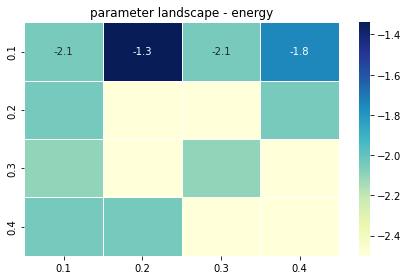

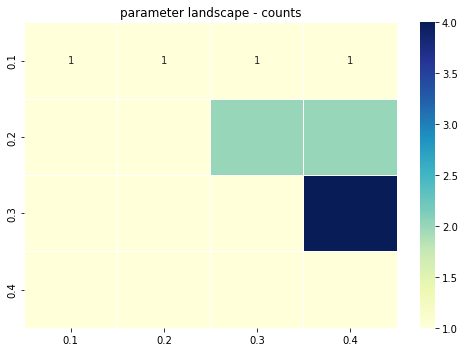

0.30000000000000004 0.4 -2.5000000000000004


In [49]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q, 100,'SV1')
print(ideal_param1, ideal_param2, lowest_energy)

Using TN1

0 1.3
1 0.51
2 0.84
3 0.75
4 0.27
5 0.15
6 0.35
7 0.25
8 0.5
9 0.6
10 0.1
T   : |0|1|    2     |    3     |    4     |         5         |         6         |             7             |              8              |                 9                  |                   10                   |                       11                       |                       12                        |                       13                       |                  14                   |                  15                  |              16              |             17              |        18         |        19         |   20   |   21    |  22   |
                                                                                                                                                                                                                                                                                                                                                              

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{436: 1, 321: 1, 1292: 1, 1525: 1, 101: 1, 332: 1, 1950: 1, 1321: 1, 987: 1, 1621: 1, 533: 1, 694: 1, 286: 1, 1202: 1, 1408: 1, 613: 1, 481: 1, 705: 1, 175: 1, 318: 1, 839: 1, 903: 1, 394: 1, 1981: 1, 1442: 1, 669: 1, 1987: 1, 2005: 1, 870: 1, 780: 1, 642: 1, 192: 1, 1919: 1, 1958: 1, 858: 1, 35: 1, 375: 1, 1254: 1, 783: 1, 1834: 1, 535: 1, 222: 1, 449: 1, 1056: 1, 846: 1, 1288: 1, 324: 1, 1122: 1, 1658: 1, 1591: 1, 634: 1, 1791: 1, 1793: 1, 453: 1, 1012: 1, 392: 1, 579: 1, 2011: 1, 134: 1, 600: 1, 1182: 1, 410: 1, 1893: 1, 1752: 1, 655: 1, 1956: 1, 954: 1, 1550: 1, 212: 1, 1477: 1, 686: 1, 991: 1, 1116: 1, 1427: 1, 1377: 1, 438: 1, 915: 1, 226: 1, 1170: 1, 2018: 1, 691: 1, 28: 1, 1392: 1, 220: 1, 702: 1, 151: 1, 1599: 1, 1618: 1, 675: 1, 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{567: 1, 273: 1, 1674: 1, 1338: 1, 1288: 1, 386: 2, 46: 1, 1195: 1, 1427: 1, 1795: 1, 1657: 1, 257: 1, 127: 1, 251: 1, 340: 1, 1524: 1, 99: 1, 398: 1, 782: 1, 822: 1, 1356: 1, 1244: 1, 1280: 1, 1073: 2, 925: 1, 537: 1, 666: 1, 1654: 1, 253: 1, 1986: 1, 752: 1, 112: 1, 852: 1, 1080: 1, 236: 1, 444: 1, 1403: 1, 1329: 1, 1178: 1, 485: 1, 125: 1, 1586: 1, 428: 1, 94: 1, 141: 1, 67: 1, 598: 1, 77: 1, 1777: 1, 1661: 1, 1273: 1, 1794: 2, 1678: 1, 921: 1, 1521: 1, 672: 1, 712: 1, 636: 1, 1326: 1, 862: 1, 123: 1, 510: 1, 219: 1, 1516: 1, 202: 1, 1264: 1, 1819: 1, 2032: 1, 1480: 1, 526: 1, 1496: 1, 189: 2, 272: 1, 451: 1, 1131: 1, 59: 1, 996: 1, 1806: 1, 615: 1, 750: 1, 1820: 1, 255: 1, 379: 1, 124: 1, 107: 1, 1233: 1, 118: 1, 1572: 1, 1919: 1, 1227

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{252: 1, 245: 1, 500: 1, 885: 1, 1579: 2, 988: 1, 968: 1, 550: 1, 1081: 2, 359: 1, 609: 1, 140: 1, 1779: 1, 780: 2, 973: 1, 327: 1, 1999: 1, 1614: 1, 515: 1, 724: 1, 1886: 1, 788: 1, 481: 1, 32: 1, 1796: 1, 775: 1, 1742: 1, 1275: 1, 623: 1, 84: 1, 620: 1, 497: 1, 1111: 1, 1547: 1, 522: 1, 1822: 1, 125: 1, 225: 1, 537: 1, 1161: 1, 1986: 1, 753: 1, 363: 1, 166: 1, 1271: 1, 1476: 1, 1564: 1, 442: 1, 1969: 1, 185: 1, 374: 1, 56: 1, 539: 1, 1078: 1, 1376: 1, 1488: 1, 113: 1, 844: 1, 76: 1, 1206: 1, 1426: 1, 1359: 1, 1280: 1, 1823: 1, 325: 1, 322: 1, 523: 1, 129: 1, 356: 1, 176: 1, 326: 1, 1504: 1, 48: 1, 142: 1, 1539: 1, 781: 1, 1321: 1, 1825: 1, 144: 1, 1595: 1, 660: 1, 1227: 1, 15: 1, 611: 1, 435: 1, 1785: 1, 308: 1, 37: 1, 1805: 1, 240: 1, 1

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{179: 1, 1870: 1, 59: 1, 843: 1, 1033: 1, 404: 2, 1934: 2, 178: 1, 1478: 1, 1818: 1, 145: 1, 1684: 1, 1259: 1, 645: 1, 1222: 1, 1186: 1, 1536: 1, 980: 1, 357: 1, 73: 1, 1476: 1, 1804: 1, 603: 1, 238: 1, 794: 2, 732: 1, 609: 1, 818: 1, 1677: 1, 94: 1, 945: 1, 793: 1, 31: 1, 385: 1, 1932: 1, 1116: 1, 1089: 1, 1694: 1, 0: 1, 186: 2, 624: 1, 241: 1, 247: 1, 1342: 1, 32: 1, 1611: 1, 369: 1, 764: 1, 1148: 1, 1096: 1, 1412: 1, 1456: 1, 1876: 1, 1860: 1, 79: 1, 1300: 1, 1884: 1, 1571: 1, 587: 1, 1036: 1, 1348: 1, 175: 1, 1670: 2, 432: 1, 379: 1, 1650: 1, 361: 1, 834: 1, 1158: 1, 1543: 1, 132: 1, 1845: 1, 1663: 1, 1796: 1, 860: 1, 772: 1, 1869: 1, 1409: 1, 62: 1, 1565: 1, 1679: 1, 2025: 1, 1272: 1, 653: 1, 1164: 1, 51: 1, 1668: 1, 1798: 1, 1137: 1,

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{844: 1, 368: 1, 857: 1, 1887: 1, 113: 1, 767: 1, 1478: 1, 1396: 1, 1313: 1, 1422: 3, 1179: 1, 103: 1, 54: 1, 795: 1, 99: 2, 1529: 1, 692: 1, 998: 1, 894: 1, 742: 1, 1321: 1, 621: 1, 700: 1, 832: 1, 375: 1, 1176: 1, 1136: 1, 282: 1, 1700: 1, 96: 1, 901: 1, 1388: 1, 79: 1, 187: 1, 782: 1, 1575: 1, 1661: 1, 1572: 1, 540: 1, 1624: 1, 228: 1, 210: 1, 1099: 1, 522: 1, 695: 1, 216: 1, 369: 1, 121: 1, 1243: 1, 1287: 1, 304: 1, 111: 1, 878: 1, 398: 1, 1382: 1, 1993: 1, 500: 1, 1696: 1, 1378: 1, 1165: 1, 1507: 1, 204: 1, 1996: 1, 507: 1, 1121: 1, 1275: 1, 336: 1, 1250: 1, 285: 1, 706: 1, 152: 1, 229: 1, 1083: 1, 2015: 1, 1819: 1, 237: 1, 1249: 1, 1200: 1, 1283: 1, 974: 1, 1: 1, 1570: 1, 959: 1, 1307: 1, 1970: 1, 964: 1, 1868: 1, 1324: 1, 371: 1, 57

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{353: 2, 123: 1, 1915: 1, 28: 1, 880: 1, 1809: 1, 1657: 1, 1679: 1, 901: 1, 368: 2, 964: 2, 1187: 1, 1424: 1, 1946: 1, 536: 1, 925: 1, 916: 1, 1267: 1, 1983: 1, 781: 1, 1393: 1, 502: 1, 1027: 1, 481: 1, 606: 1, 526: 2, 569: 1, 1476: 1, 1135: 1, 1817: 1, 1217: 1, 784: 1, 240: 1, 740: 1, 1162: 1, 780: 1, 1625: 1, 1117: 1, 81: 1, 541: 1, 480: 1, 1521: 1, 1870: 1, 845: 1, 1415: 1, 515: 1, 966: 1, 1699: 1, 538: 1, 645: 1, 129: 1, 1220: 1, 1667: 1, 768: 1, 785: 1, 1300: 1, 1012: 1, 627: 1, 337: 1, 1180: 1, 1970: 1, 1339: 1, 631: 1, 112: 1, 372: 1, 544: 1, 1551: 1, 1395: 1, 186: 1, 225: 1, 1690: 1, 24: 1, 1921: 1, 1794: 1, 134: 1, 633: 1, 900: 1, 978: 1, 477: 1, 15: 1, 711: 1, 975: 1, 114: 1, 493: 1, 433: 1, 260: 1, 1528: 1, 1599: 1, 772: 1, 762:

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1595: 1, 1629: 1, 1071: 1, 508: 2, 1675: 1, 1420: 1, 1058: 1, 114: 1, 1696: 1, 142: 1, 1988: 1, 95: 1, 1547: 1, 1615: 1, 959: 1, 1509: 1, 1551: 1, 1726: 1, 604: 1, 64: 1, 435: 1, 4: 2, 601: 1, 1210: 1, 171: 1, 1082: 1, 48: 1, 226: 1, 606: 1, 1886: 1, 240: 2, 376: 1, 326: 1, 130: 1, 96: 1, 3: 1, 771: 1, 2038: 1, 861: 1, 581: 1, 400: 2, 1933: 1, 639: 1, 1823: 1, 1670: 2, 1392: 1, 1421: 1, 964: 1, 106: 1, 1801: 1, 555: 1, 537: 1, 152: 1, 1523: 1, 589: 1, 522: 1, 78: 1, 563: 1, 1400: 1, 836: 1, 69: 1, 1150: 1, 1919: 1, 1934: 1, 73: 1, 1203: 1, 1520: 1, 432: 1, 544: 1, 1870: 1, 324: 1, 434: 1, 497: 1, 863: 1, 542: 1, 607: 1, 224: 1, 1694: 1, 13: 1, 1887: 1, 257: 1, 246: 1, 51: 1, 1253: 1, 256: 1, 2019: 1, 1476: 1, 132: 1, 14: 1, 241: 1, 1609: 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{50: 1, 836: 2, 1996: 1, 109: 1, 1625: 1, 49: 1, 448: 2, 145: 1, 230: 1, 177: 2, 1138: 1, 1920: 2, 1456: 1, 1344: 1, 241: 1, 272: 2, 1393: 1, 176: 1, 525: 1, 372: 1, 46: 1, 100: 1, 652: 1, 1818: 1, 543: 1, 65: 1, 368: 1, 1798: 1, 348: 1, 1934: 1, 1507: 1, 34: 1, 452: 1, 254: 1, 1210: 1, 134: 1, 1921: 1, 384: 1, 1767: 1, 1887: 1, 786: 1, 132: 1, 204: 2, 120: 1, 1547: 1, 381: 1, 1550: 1, 153: 1, 1667: 1, 1551: 1, 112: 1, 591: 2, 238: 1, 1193: 1, 1698: 1, 1794: 1, 432: 1, 196: 1, 163: 1, 1194: 1, 1058: 1, 1635: 1, 289: 1, 33: 1, 333: 1, 138: 1, 336: 1, 1743: 1, 121: 1, 622: 1, 288: 1, 650: 1, 796: 1, 768: 1, 1281: 1, 505: 1, 190: 1, 1675: 1, 797: 1, 1521: 1, 1378: 1, 324: 1, 497: 1, 605: 1, 529: 1, 1398: 1, 141: 1, 1896: 1, 604: 1, 900: 1, 88

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1167: 1, 1547: 1, 1294: 1, 1939: 1, 1901: 1, 220: 1, 210: 1, 1628: 2, 1346: 1, 892: 1, 78: 1, 1029: 1, 860: 1, 1054: 1, 890: 1, 895: 1, 473: 1, 114: 1, 1659: 1, 688: 1, 1924: 1, 1276: 1, 909: 1, 926: 1, 1857: 1, 1293: 1, 250: 1, 543: 1, 252: 1, 1929: 1, 1898: 1, 1662: 1, 279: 1, 816: 1, 1563: 1, 1275: 1, 420: 1, 1395: 1, 102: 1, 1946: 1, 1403: 1, 636: 1, 1797: 1, 613: 1, 322: 1, 775: 1, 912: 2, 1695: 1, 55: 1, 1033: 1, 23: 1, 111: 1, 1582: 1, 536: 1, 1876: 1, 337: 1, 1565: 1, 49: 1, 977: 1, 385: 1, 650: 1, 933: 1, 1351: 1, 139: 1, 1872: 1, 1671: 1, 988: 1, 1396: 1, 825: 1, 1886: 1, 182: 1, 715: 1, 1372: 1, 1970: 1, 2006: 1, 117: 1, 1373: 1, 879: 1, 1197: 1, 1138: 1, 906: 1, 897: 1, 130: 1, 2013: 1, 1807: 1, 1523: 1, 1349: 1, 1023: 1, 324:

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1356: 1, 496: 2, 538: 1, 1202: 1, 1969: 1, 1827: 2, 1935: 1, 500: 1, 260: 1, 1595: 1, 325: 1, 1154: 1, 900: 1, 113: 1, 1230: 1, 1663: 1, 1027: 1, 1878: 1, 1647: 2, 18: 1, 1671: 1, 581: 1, 400: 1, 1166: 1, 58: 1, 1933: 1, 1275: 1, 1161: 1, 1412: 1, 224: 1, 651: 1, 897: 1, 67: 1, 121: 2, 160: 1, 127: 1, 1613: 1, 35: 1, 947: 1, 1923: 1, 926: 1, 1349: 1, 252: 1, 530: 1, 739: 1, 513: 1, 772: 1, 1615: 1, 1666: 1, 1934: 1, 98: 1, 688: 1, 324: 2, 80: 1, 558: 1, 108: 1, 1529: 1, 388: 1, 1364: 1, 504: 1, 1787: 1, 369: 1, 847: 1, 996: 1, 1818: 1, 1250: 1, 1344: 1, 102: 1, 1328: 1, 107: 1, 1823: 1, 1758: 1, 1426: 1, 1137: 1, 1153: 1, 1394: 1, 1160: 1, 1562: 1, 796: 1, 425: 1, 326: 1, 609: 1, 1950: 1, 508: 1, 99: 1, 1699: 1, 1927: 1, 130: 1, 1760: 1, 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{485: 1, 89: 1, 101: 1, 69: 1, 794: 1, 99: 1, 734: 1, 113: 2, 1249: 1, 857: 1, 272: 1, 526: 1, 1950: 1, 248: 1, 1520: 1, 2014: 1, 240: 3, 356: 1, 775: 1, 900: 2, 1470: 1, 796: 1, 1674: 1, 848: 2, 1938: 2, 1838: 1, 797: 1, 50: 1, 1583: 1, 771: 1, 860: 1, 139: 1, 59: 1, 650: 1, 112: 1, 384: 1, 1915: 1, 1595: 1, 130: 1, 822: 1, 369: 2, 58: 1, 1485: 1, 1562: 1, 1067: 1, 1865: 1, 225: 1, 1420: 1, 484: 1, 322: 1, 1667: 1, 1551: 1, 1679: 1, 1926: 1, 881: 1, 97: 1, 784: 1, 0: 1, 163: 1, 235: 1, 1663: 1, 828: 1, 224: 1, 605: 1, 1922: 1, 530: 1, 162: 2, 1039: 1, 35: 1, 106: 1, 861: 1, 1678: 1, 752: 1, 340: 1, 524: 1, 852: 1, 1211: 1, 1702: 1, 589: 1, 588: 1, 65: 1, 178: 1, 1166: 1, 1886: 1, 590: 1, 73: 1, 425: 1, 1392: 1, 77: 1, 525: 1, 102: 1, 1505

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1123: 2, 1350: 1, 1810: 1, 1793: 1, 324: 4, 128: 3, 833: 1, 124: 1, 1082: 1, 35: 1, 384: 1, 772: 2, 143: 1, 1595: 1, 1659: 1, 525: 1, 173: 1, 49: 1, 10: 1, 1806: 1, 654: 1, 1907: 1, 789: 1, 1313: 2, 639: 1, 25: 2, 417: 1, 526: 2, 794: 1, 861: 1, 160: 1, 1155: 1, 1414: 1, 1505: 1, 1456: 1, 1924: 1, 186: 1, 1934: 1, 837: 2, 117: 1, 773: 1, 1562: 1, 1187: 1, 839: 1, 900: 1, 161: 1, 653: 1, 1691: 1, 123: 2, 113: 1, 646: 1, 845: 1, 1926: 1, 1921: 1, 340: 1, 1860: 1, 780: 1, 590: 1, 649: 1, 1871: 2, 1504: 1, 321: 1, 252: 1, 336: 1, 1400: 1, 1147: 1, 184: 1, 1811: 1, 400: 1, 1296: 1, 1210: 1, 0: 1, 325: 1, 1551: 2, 784: 1, 61: 1, 605: 1, 348: 1, 133: 1, 844: 1, 1817: 1, 1145: 1, 1538: 1, 1931: 1, 178: 1, 1807: 1}
0 1.3
1 0.51
2 0.84
3 0.75
4 0.2

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{152: 1, 1775: 1, 1574: 1, 836: 1, 1722: 1, 1104: 1, 993: 1, 41: 1, 1140: 2, 1280: 1, 165: 1, 1927: 1, 1937: 2, 188: 1, 166: 1, 388: 1, 635: 1, 1026: 1, 1115: 1, 251: 1, 2028: 2, 1870: 1, 543: 1, 537: 1, 128: 1, 1253: 1, 1637: 1, 1035: 1, 1678: 1, 1565: 1, 1556: 1, 191: 1, 1338: 1, 496: 1, 220: 1, 1557: 1, 973: 1, 1946: 1, 1890: 1, 33: 1, 848: 1, 1460: 2, 172: 1, 768: 1, 662: 1, 1823: 1, 3: 1, 862: 1, 1536: 1, 1357: 1, 113: 1, 1899: 1, 1133: 1, 269: 1, 1911: 1, 226: 1, 1394: 1, 1207: 1, 741: 1, 1788: 1, 1309: 1, 92: 1, 391: 1, 1407: 1, 106: 1, 98: 1, 178: 1, 1149: 1, 1067: 2, 682: 1, 1912: 1, 1933: 1, 517: 1, 1679: 1, 539: 2, 1082: 1, 448: 1, 711: 1, 1362: 1, 1966: 2, 239: 1, 609: 1, 348: 1, 306: 1, 370: 1, 1410: 1, 1562: 1, 668: 1, 1467: 

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{1647: 2, 1547: 1, 498: 2, 113: 1, 589: 1, 434: 1, 860: 1, 368: 1, 1088: 1, 304: 1, 1869: 2, 1967: 2, 171: 1, 196: 1, 838: 1, 254: 1, 848: 1, 514: 1, 653: 1, 392: 1, 1562: 1, 1815: 1, 170: 1, 60: 1, 204: 1, 862: 1, 1894: 1, 336: 1, 604: 1, 322: 1, 832: 1, 500: 1, 845: 1, 686: 1, 763: 1, 327: 1, 299: 1, 420: 1, 1563: 1, 335: 1, 1726: 1, 1665: 1, 836: 1, 317: 1, 609: 2, 1508: 1, 190: 1, 20: 1, 730: 1, 177: 1, 1958: 1, 1822: 1, 162: 1, 1710: 1, 76: 1, 99: 1, 492: 1, 1868: 1, 1387: 1, 69: 1, 1798: 2, 132: 1, 34: 1, 156: 1, 130: 1, 188: 1, 1871: 1, 593: 1, 1: 1, 1520: 1, 590: 1, 1551: 1, 182: 1, 142: 1, 1859: 1, 1075: 1, 140: 1, 1794: 1, 1529: 1, 163: 1, 1870: 1, 1921: 1, 56: 1, 1813: 1, 1539: 1, 1611: 1, 1116: 1, 504: 1, 877: 1, 388: 1, 275: 1

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{176: 1, 96: 1, 1144: 1, 320: 1, 588: 2, 1200: 3, 3: 1, 589: 1, 1074: 1, 160: 1, 527: 1, 35: 2, 126: 1, 152: 1, 368: 1, 542: 1, 1978: 1, 1551: 1, 836: 1, 1393: 1, 642: 1, 1203: 1, 1248: 1, 4: 1, 0: 1, 79: 1, 582: 1, 1822: 2, 1008: 1, 388: 1, 1396: 1, 924: 1, 893: 1, 373: 1, 1807: 1, 639: 1, 676: 1, 635: 1, 793: 1, 1547: 1, 182: 1, 496: 1, 1795: 1, 128: 1, 1885: 1, 679: 1, 2012: 1, 14: 1, 390: 1, 1915: 1, 637: 1, 1814: 1, 1579: 1, 466: 1, 164: 1, 1408: 1, 1945: 1, 324: 1, 605: 1, 123: 1, 121: 1, 1674: 1, 1185: 1, 369: 1, 1882: 1, 113: 1, 529: 1, 964: 1, 77: 1, 1268: 1, 860: 2, 1647: 1, 645: 1, 109: 1, 1595: 2, 1665: 1, 1997: 1, 315: 1, 1675: 1, 1161: 1, 372: 1, 1954: 1, 1679: 1, 1137: 1, 1630: 1, 771: 1, 1539: 1, 452: 1, 257: 1, 525: 1, 384

Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 100
simulator cost per  minute : $ 0.275
total cost cannot be estimated
{588: 1, 1393: 1, 1210: 1, 900: 2, 13: 1, 536: 1, 2034: 1, 76: 1, 656: 1, 905: 1, 299: 1, 99: 1, 1: 1, 161: 1, 10: 1, 881: 1, 115: 1, 1395: 1, 1678: 1, 1184: 1, 820: 1, 111: 1, 49: 1, 811: 1, 0: 1, 526: 1, 1187: 2, 1335: 1, 500: 1, 1929: 1, 527: 3, 1510: 1, 589: 1, 256: 1, 101: 1, 538: 1, 59: 1, 1202: 1, 1563: 1, 162: 2, 525: 1, 96: 1, 1561: 1, 1147: 1, 320: 1, 132: 1, 114: 1, 772: 1, 1347: 1, 1528: 1, 352: 1, 381: 1, 541: 1, 1659: 1, 163: 1, 780: 1, 624: 1, 1520: 1, 220: 1, 336: 1, 48: 1, 635: 1, 1719: 1, 1082: 1, 240: 1, 1547: 1, 1615: 1, 1860: 1, 1934: 1, 113: 1, 652: 1, 1670: 1, 1822: 1, 1873: 1, 112: 1, 1838: 2, 1200: 1, 68: 1, 591: 1, 307: 1, 844: 1, 69: 1, 1250: 1, 784: 1, 97: 2, 639: 1, 496: 1, 773: 1, 128: 1, 1440: 1, 782: 1, 1211

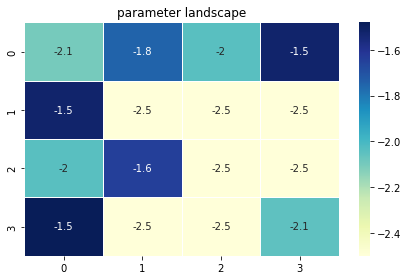

In [133]:
ideal_param1, ideal_param2, lowest_energy=param_optimizer_device(param, param, Q, 100,'TN1')
print(ideal_param1, ideal_param2, lowest_energy)

### Find minimum using fixed parameters

In [110]:
#---------
param1=[0.25]
param2=[0.28]
shots=5000
#---------

Using Local Simulator

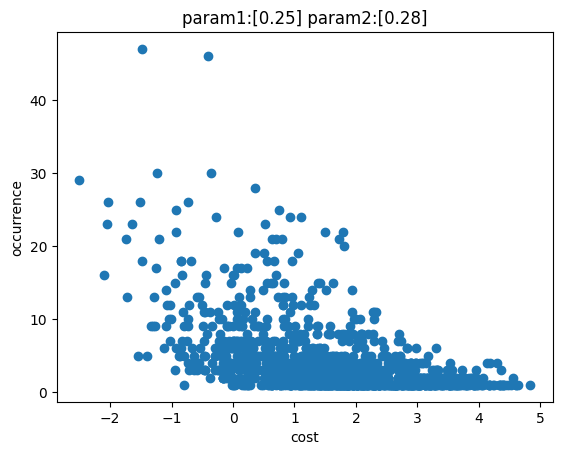

11000001111 -2.5000000000000004 29


In [111]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

### Scheduling Tasks

Using SV1

In [132]:
param1=[0.25]
param2=[0.28]
shots=5000

In [133]:
device=set_device('SV1')
estimate_cost(device,num_shots=shots)

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
simulator cost per  minute : $ 0.075
total cost cannot be estimated


In [ ]:
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

5000 shots taken on machine arn:aws:braket:::device/quantum-simulator/amazon/sv1.


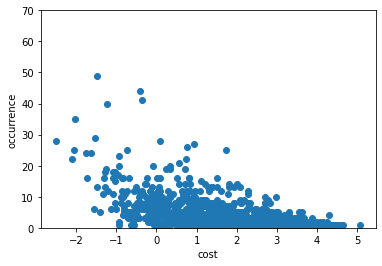

solution 11000001111 , min energy found -2.5000000000000004 ,  28  instances found


In [142]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
index=np.argsort(energy)
#plt.scatter(energy,quantity)
#plt.show()
#print('minimum found', energy[index[0]])
#actual_simulator_cost(device, results)
#plt.title('param1:'+str(param1)+' param2:'+str(param2))
plt.xlabel('energy')
#plt.xlim(-3, 8)
plt.ylabel('occurrence')
plt.ylim(0,70)
#plt.ylim(0,2700)
plt.scatter(energy,quantity)

plt.show()
print('solution',solution[index[0]],', min energy found',energy[index[0]],', ',quantity[index[0]],' instances found')

In [64]:
actual_simulator_cost(device, results)

simulator cost per  minute : $ 0.075
total execution time:  27 ms
total cost estimated: $ 3.375e-05


Using IonQ

In [147]:
# Select the appropriate IonQ device below


device=set_device('Harmony')
#device=set_device('Aria 2')

Device('name': Harmony, 'arn': arn:aws:braket:us-east-1::device/qpu/ionq/Harmony)


In [148]:
shots=estimate_cost_measured_qubits(device,11)

max shots: 10000
for 11 measured qubits the maximum allowed shots: 10,000
device cost per  shot : $ 0.01
total cost for 10000 shots is $100.30


In [150]:
shots=5000
estimate_cost(device,num_shots=shots)

device cost per  shot : $ 0.01
total cost for 5000 shots is $50.30


In [151]:
print(param1, param2)

[0.25] [0.28]


In [ ]:
# Warning
# If you are running this yourself, please note the cost before executing. It can be up to $150. Uncomment below to run.

task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

Using Harmony

In [ ]:
#harmony
task_id='[your task id]'

1000 shots taken on machine arn:aws:braket:us-east-1::device/qpu/ionq/Harmony.


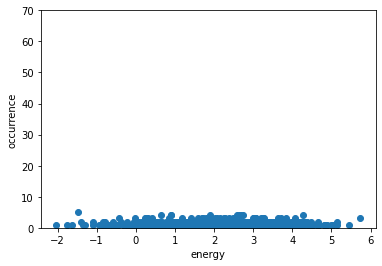

solution 11000001011 , min energy found -2.0399999999999996 ,  1  instances found


In [157]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
index=np.argsort(energy)
#plt.scatter(energy,quantity)
#plt.show()
#print('minimum found', energy[index[0]])
#actual_simulator_cost(device, results)
#plt.title('param1:'+str(param1)+' param2:'+str(param2))
plt.xlabel('energy')
#plt.xlim(-3, 8)
plt.ylabel('occurrence')
plt.ylim(0,70)
#plt.ylim(0,2700)
plt.scatter(energy,quantity)

plt.show()
print('solution',solution[index[0]],', min energy found',energy[index[0]],', ',quantity[index[0]],' instances found')

Using Aria 2

In [158]:
#Aria 2 task
task_id='[your task id]'

5000 shots taken on machine arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2.


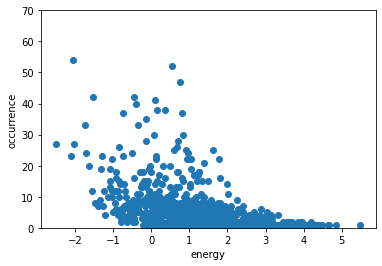

solution 11000001111 , min energy found -2.5000000000000004 ,  27  instances found


In [159]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
index=np.argsort(energy)
#plt.scatter(energy,quantity)
#plt.show()
#print('minimum found', energy[index[0]])
#actual_simulator_cost(device, results)
#plt.title('param1:'+str(param1)+' param2:'+str(param2))
plt.xlabel('energy')
#plt.xlim(-3, 8)
plt.ylabel('occurrence')
plt.ylim(0,70)
#plt.ylim(0,2700)
plt.scatter(energy,quantity)

plt.show()
print('solution',solution[index[0]],', min energy found',energy[index[0]],', ',quantity[index[0]],' instances found')

In [ ]:
# Adjust code to use Aspen-M-3 as of April 2023

Using Aspen M-3

In [161]:
param1=[0.25]
param2=[0.28]
Qubits=11

In [162]:
device=set_device('Aspen-M-3')
shots=estimate_cost_measured_qubits(device,Qubits)
#shots=5000
print(shots)
estimate_cost(device,num_shots=shots)

Device('name': Aspen-M-3, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3)
max shots: 100000
for 11 measured qubits the number of shots recommended: 51,200
device cost per  shot : $ 0.00035
total cost for 51200 shots is $18.22
5000
device cost per  shot : $ 0.00035
total cost for 5000 shots is $2.05


In [ ]:
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

In [ ]:
# you will find your task in https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/tasks

In [53]:
# Rigetti Aspen M-3
task_id='[your task id]'

51200 shots taken on machine arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3.


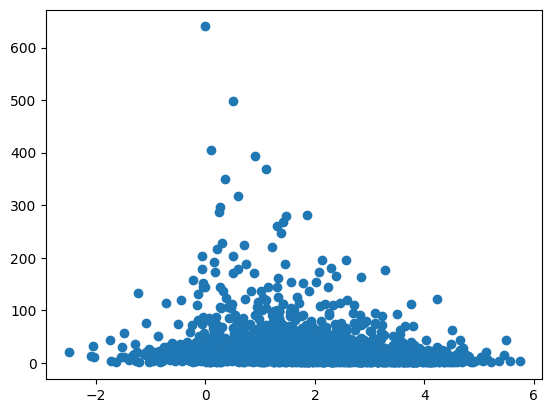

minimum found -2.5000000000000004


In [48]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
index=np.argsort(energy)
#plt.scatter(energy,quantity)
#plt.show()
#print('minimum found', energy[index[0]])
#actual_simulator_cost(device, results)
#plt.title('param1:'+str(param1)+' param2:'+str(param2))
plt.xlabel('energy')
#plt.xlim(-3, 8)
plt.ylabel('occurrence')
plt.ylim(0,70)
#plt.ylim(0,2700)
plt.scatter(energy,quantity)

plt.show()
print('solution',solution[index[0]],', min energy found',energy[index[0]],', ',quantity[index[0]],' instances found')

In [ ]:
# Able to find the minimum -2.5 using Rigetti

Determine minimum using multiple step parameters

Using optimal values found for 2 cycles

Using fixed parameters and Local Simulator

In [89]:
#---------
param1=[0.3, 0.3]
param2=[0.4, 0.4]
shots=5000
#---------

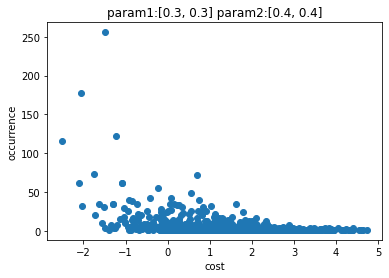

11000001111 -2.5000000000000004 116


In [90]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

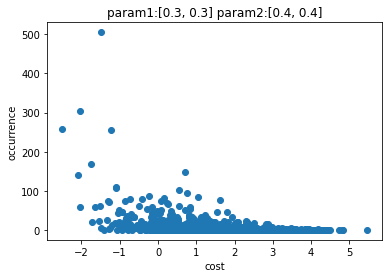

11000001111 -2.5000000000000004 259


In [80]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

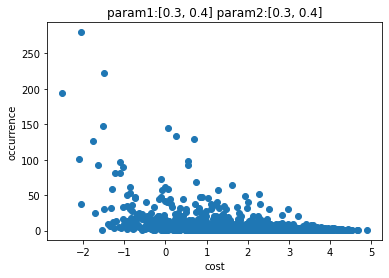

11000001111 -2.5000000000000004 194


In [78]:
solution,energy,quantity=optimize_bqm(param1, param2, Q, shots)
print(solution, energy, quantity)

Using IonQ

In [91]:
#---------
param1=[0.3, 0.3]
param2=[0.4, 0.4]
shots=5000
#---------

In [92]:
device=set_device('Aria 2')

Device('name': Aria 2, 'arn': arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2)


In [93]:
estimate_cost(device,num_shots=shots)

device cost per  shot : $ 0.03
total cost for 5000 shots is $150.30


In [ ]:
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

In [95]:
task_id='[your task id]'

In [ ]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
energy_np=np.array(energy)
index=np.argsort(energy)
plt.scatter(energy,quantity)
plt.show()
print('minimum found', energy[index[0]])

Using Rigetti

In [ ]:
# Adjust code to use Aspen-M-3 as of April 2023

In [ ]:
shots=5000
device=set_device('Aspen-M-3')
estimate_cost(device,num_shots=shots)
task_id=schedule_optimize_bqm_task(param1, param2, Q, shots, device)
print(task_id)

In [164]:
task_id='[your task id]'

5000 shots taken on machine arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3.


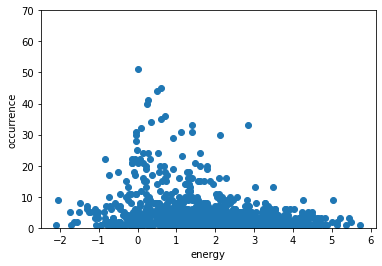

solution 11000001110 , min energy found -2.0999999999999996 ,  1  instances found


In [165]:
results, metadata, counts=recover_task(task_id)
solution=[]
quantity=[]
energy=[]
for keys,values in zip(counts.keys(),counts.values()):
    solution.append(keys)
    quantity.append(values)
    energy.append(sum_energy(Q,keys))
index=np.argsort(energy)
#plt.scatter(energy,quantity)
#plt.show()
#print('minimum found', energy[index[0]])
#actual_simulator_cost(device, results)
#plt.title('param1:'+str(param1)+' param2:'+str(param2))
plt.xlabel('energy')
#plt.xlim(-3, 8)
plt.ylabel('occurrence')
plt.ylim(0,70)
#plt.ylim(0,2700)
plt.scatter(energy,quantity)

plt.show()
print('solution',solution[index[0]],', min energy found',energy[index[0]],', ',quantity[index[0]],' instances found')

In [ ]:
------------------------------------- End --------------------------